In [1]:
import pandas as pd
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline

In [2]:
sepsis = pd.read_csv('Sepsis_Compiled_Full.csv',index_col=0)

/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


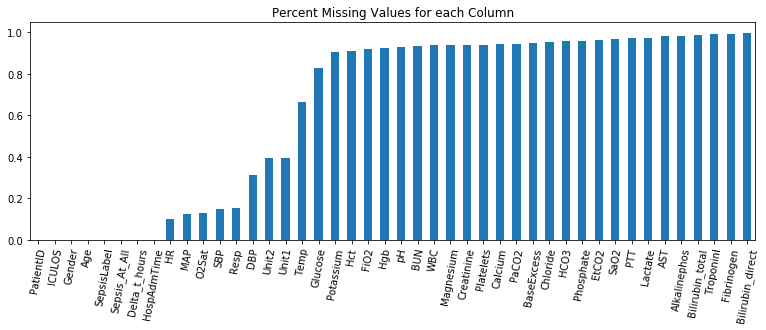

In [21]:
plt.figure(figsize=(13,4))
(sepsis.isna().sum().sort_values()/sepsis.shape[0]).plot.bar()
plt.xticks(rotation = 80)
plt.title('Percent Missing Values for each Column')
plt.show()

In [18]:
sepsis.isna().sum().sort_values() / sepsis.shape[0]

PatientID           0.000000
ICULOS              0.000000
Gender              0.000000
Age                 0.000000
SepsisLabel         0.000000
Sepsis_At_All       0.000000
Delta_t_hours       0.000000
HospAdmTime         0.000005
HR                  0.098826
MAP                 0.124513
O2Sat               0.130611
SBP                 0.145770
Resp                0.153546
DBP                 0.313459
Unit2               0.394251
Unit1               0.394251
Temp                0.661627
Glucose             0.828943
Potassium           0.906891
Hct                 0.911460
FiO2                0.916658
Hgb                 0.926176
pH                  0.930697
BUN                 0.931344
WBC                 0.935932
Magnesium           0.936896
Creatinine          0.939044
Platelets           0.940595
Calcium             0.941161
PaCO2               0.944401
BaseExcess          0.945790
Chloride            0.954603
HCO3                0.958106
Phosphate           0.959863
EtCO2         

In [22]:
sepsis.head()

PatientID  Delta_t_hours    HR  O2Sat   Temp     SBP   MAP    DBP  Resp  \
0   p014977              0  80.0  100.0  36.50  121.00  58.0  41.00  13.5   
1   p014977              1  76.0  100.0  36.25  113.25  61.0  41.50  12.0   
2   p014977              2  80.0  100.0  36.25  132.75  71.5  46.25  12.0   
3   p014977              3  78.0  100.0  36.10  103.50  58.0  43.00  12.0   
4   p014977              4  74.0  100.0  36.00  128.75  69.5  44.50  12.5   

   EtCO2  BaseExcess  HCO3  FiO2    pH  PaCO2  SaO2  AST   BUN  Alkalinephos  \
0    NaN         1.0  25.0   1.0  7.40   47.0  77.0  NaN  53.0           NaN   
1    NaN         1.0  25.0   0.5  7.40    NaN   NaN  NaN  53.0           NaN   
2    NaN         NaN   NaN   NaN   NaN    NaN   NaN  NaN   NaN           NaN   
3    NaN        -3.0   NaN   NaN  7.34   42.0   NaN  NaN   NaN           NaN   
4    NaN        -3.0   NaN   NaN  7.34    NaN   NaN  NaN   NaN           NaN   

   Calcium  Chloride  Creatinine  Bilirubin_direct  Glucose  Lactate  \
0      NaN     111.0         2.1               NaN    107.0      2.4   
1      NaN     111.0         NaN               NaN      NaN      NaN   
2      NaN       NaN         NaN               NaN      NaN      NaN   
3      NaN       NaN         NaN               NaN    112.5      NaN   
4      NaN       NaN         NaN               NaN      NaN      NaN   

   Magnesium  Phosphate  Potassium  Bilirubin_total  TroponinI   Hct  Hgb  \
0        NaN        NaN        3.7              NaN        NaN  27.9  8.8   
1        NaN        NaN        NaN              NaN        NaN  27.9  8.8   
2        NaN        NaN        NaN              NaN        NaN   NaN  NaN   
3        NaN        NaN        4.2              NaN        NaN   NaN  NaN   
4        NaN        NaN        NaN              NaN        NaN   NaN  NaN   

    PTT  WBC  Fibrinogen  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  \
0  38.1  9.9       223.0      160.0  77.27       1    0.0    1.0       -69.14   
1   NaN  9.9         NaN        NaN  77.27       1    0.0    1.0       -69.14   
2   NaN  NaN         NaN        NaN  77.27       1    0.0    1.0       -69.14   
3   NaN  NaN         NaN        NaN  77.27       1    0.0    1.0       -69.14   
4   NaN  NaN         NaN        NaN  77.27       1    0.0    1.0       -69.14   

   ICULOS  SepsisLabel  Sepsis_At_All  
0       3            0              0  
1       4            0              0  
2       5            0              0  
3       6            0              0  
4       7            0              0

* SepsisLabel indicates that the person developed sepsis 6 hours after the current delta_t
* Sepsis_At_All indicates whether or not the person developed sepsis
* First check the sums in this column are different

In [7]:
sum(sepsis['SepsisLabel']),sum(sepsis['Sepsis_At_All'])

(27916, 172410)

* Notes on the labels
* The original label is decomposed into two times: $t_{suspicision}$ and $t_{SOFA}$
* $t_{suspicision}$ is the time at which suspicison of sepsis has been delcared byt lab cultues
* $t_{SOFA}$ is the time marked when there is a two point deterioration in SOFA score
* $t_{sepsis}$ is the $min(t_{suspicion},t_{SOFA})$
* we don't know exactly when the patient developed sepsis, but we do know that if it marked at 1, then that patient developed sepsis at least 6 hours later!
* Lets get the distributions for onset of sepsis after being admitted into the ICU

In [83]:
time_to_sepsis = []
total_times_with_sepsis = []
gender = []
ages = []
hospadmittime = []
for a,b in sepsis.groupby("PatientID"):
    #check in column for sepsis label
    if b['Sepsis_At_All'][0] == 1:
        #find the idx of the first occurence
        idx = 0
        for i in range(0,len(b['Sepsis_At_All'])):
            if b['Sepsis_At_All'][i] == 1:
                idx = i
                break
        #look up ICU time at the idx and 6 hours then append
        time_start = b['ICULOS'][idx]+ 6
        time_to_sepsis.append(time_start)
        #now get the total time withe Sepsis
        time_end = b['ICULOS'].iloc[-1] + 6
        total_times_with_sepsis.append(time_end-time_start)
        gender.append('M' if b['Gender'][0] == 1 else 'F')
        ages.append(int(b['Age'][0]))
        hospadmittime.append(b['HospAdmTime'][0])
    else:
        pass



In [56]:
len(time_to_sepsis),len(total_times_with_sepsis)

(2932, 2932)

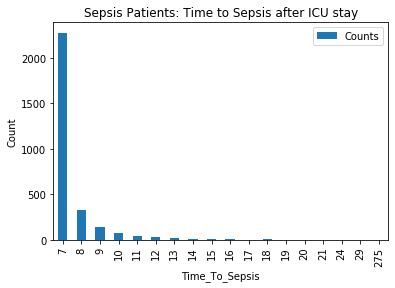

In [57]:
a,b = np.unique(time_to_sepsis,return_counts=True)
times = pd.DataFrame()
times['Time_To_Sepsis'] = a
times['Counts'] = b
times.plot.bar(x='Time_To_Sepsis',y='Counts')
plt.title('Sepsis Patients: Time to Sepsis after ICU stay')
plt.ylabel('Count')
plt.show()
#Could also split by gender??

In [84]:
times = pd.DataFrame()
times['Time_To_Sepsis'] = time_to_sepsis
times['Times_With_Sepsis'] = total_times_with_sepsis
times['Gender'] =gender
times['Age'] = ages
times['HospAdmit_minus_ICU_admit'] = hospadmittime
times.head()

Time_To_Sepsis  Times_With_Sepsis Gender  Age  HospAdmit_minus_ICU_admit
0               7                257      M   27                      -0.03
1               8                 33      M   65                      -0.02
2               7                 14      F   58                    -405.34
3               7                133      M   39                      -0.02
4              11                 18      F   77                    -135.81

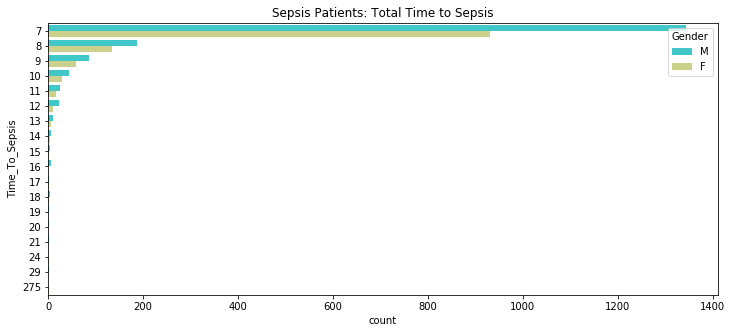

In [85]:
plt.figure(figsize=(12,5))
sns.countplot(y='Time_To_Sepsis',hue='Gender',data=times,palette='rainbow')
plt.title("Sepsis Patients: Total Time to Sepsis")
plt.show()

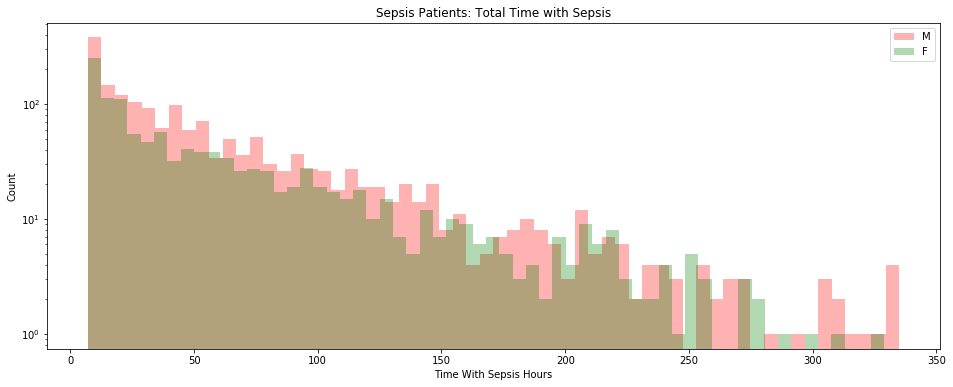

In [129]:
plt.figure(figsize=(16,6))
for foo in [['M','red'],['F','green']]:
    series = times[times['Gender'] == foo[0]]['Times_With_Sepsis']
    plt.hist(series,bins=60,color=foo[1],alpha=0.3,label=foo[0])
plt.title('Sepsis Patients: Total Time with Sepsis')
plt.xlabel('Time With Sepsis Hours')
plt.ylabel('Count')
plt.yscale('log')
plt.legend()
plt.show()


Looks like a half of a really wide gaussian!

Is there a lag between hosp admit time and ICU admit time?

In [109]:
times['HospAdmit_minus_ICU_admit'] = np.abs(times['HospAdmit_minus_ICU_admit'].values)

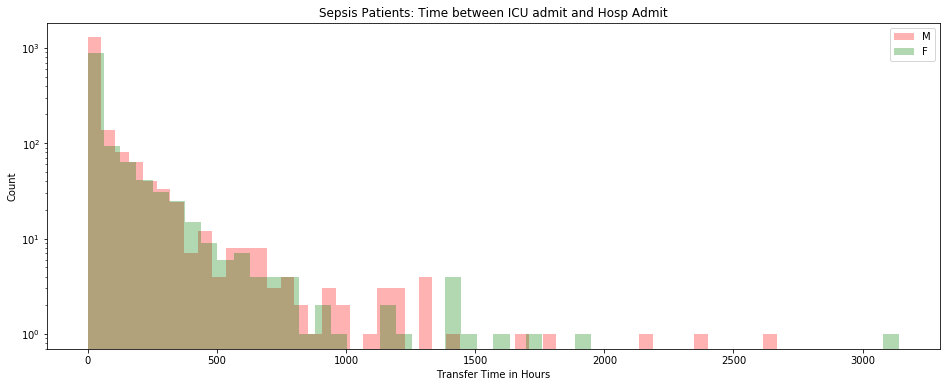

In [130]:
plt.figure(figsize=(16,6))
for foo in [['M','red'],['F','green']]:
    series = times[times['Gender'] == foo[0]]['HospAdmit_minus_ICU_admit']
    plt.hist(series,bins=50,color=foo[1],alpha=0.3,label=foo[0])
plt.title('Sepsis Patients: Time between ICU admit and Hosp Admit')
plt.xlabel('Transfer Time in Hours')
plt.ylabel('Count')
plt.yscale('log')
plt.legend()
plt.show()

Also half of a gaussian

In [149]:
times.groupby('Gender').agg([np.mean,len,np.std,np.median,min,max])

Time_To_Sepsis                                 Times_With_Sepsis        \
                 mean   len       std median min  max              mean   len   
Gender                                                                          
F            7.688181  1193  7.842622      7   7  275         58.337804  1193   
M            7.564117  1739  1.553348      7   7   29         57.435883  1739   

                                         Age                                   \
              std median min  max       mean   len        std median min  max   
Gender                                                                          
F       59.442819     36   7  329  62.906119  1193  16.762741     65  18  100   
M       59.021507     37   7  335  60.951121  1739  16.044437     62  17  100   

       HospAdmit_minus_ICU_admit                                           
                            mean     len         std median  min      max  
Gender                                                                     
F                      84.009606  1193.0  211.337917   4.16  0.0  3141.55  
M                      75.196935  1739.0  198.979688   2.39  0.0  2668.77

In [150]:
times.groupby('Age').agg([np.mean,len,np.std,np.median,min,max])

Time_To_Sepsis                                Times_With_Sepsis      \
              mean len        std median min  max              mean len   
Age                                                                       
17        7.000000   2   0.000000      7   7    7         21.500000   2   
18        7.000000   5   0.000000      7   7    7         74.800000   5   
19        7.200000   5   0.447214      7   7    8         49.200000   5   
20        7.625000  16   1.408309      7   7   11         44.937500  16   
21        7.333333  12   0.887625      7   7   10         63.833333  12   
22        7.600000  15   1.298351      7   7   11         93.600000  15   
23        7.714286   7   1.889822      7   7   12         52.857143   7   
24        7.333333   9   0.707107      7   7    9        102.333333   9   
25        8.428571   7   3.359422      7   7   16         45.142857   7   
26        7.500000  14   0.854850      7   7   10         39.714286  14   
27        7.863636  22   2.512738      7   7   18         58.363636  22   
28        7.125000  16   0.500000      7   7    9         35.937500  16   
29        7.153846  13   0.375534      7   7    8         81.076923  13   
30        7.500000  12   0.797724      7   7    9         81.250000  12   
31        7.200000  15   0.560612      7   7    9         23.800000  15   
32        7.428571  14   1.089410      7   7   10         60.285714  14   
33        7.600000  10   1.074968      7   7   10         81.200000  10   
34        7.368421  19   0.955134      7   7   11         39.052632  19   
35        7.357143  14   0.744946      7   7    9         64.000000  14   
36        7.222222   9   0.666667      7   7    9         20.555556   9   
37        8.176471  17   2.811479      7   7   18         78.529412  17   
38        7.105263  19   0.315302      7   7    8         56.263158  19   
39        7.551724  29   1.403725      7   7   12         39.103448  29   
40        7.142857  21   0.358569      7   7    8         57.285714  21   
41        7.548387  31   1.260654      7   7   12         47.677419  31   
42        7.428571  35   0.884032      7   7   10         49.171429  35   
43        7.531250  32   1.367465      7   7   14         51.750000  32   
44        7.400000  35   1.142752      7   7   12         46.400000  35   
45        7.428571  35   1.037126      7   7   12         82.657143  35   
46        7.250000  32   0.803219      7   7   11         51.687500  32   
47        7.782609  46   2.250067      7   7   20         48.608696  46   
48        7.346939  49   1.234082      7   7   15         61.836735  49   
49        7.421053  38   1.153879      7   7   12         45.552632  38   
50        7.431373  51   1.360219      7   7   16         57.372549  51   
51        7.410256  39   0.880130      7   7   11         42.666667  39   
52        7.352941  51   1.323987      7   7   16         50.529412  51   
53        7.580000  50   1.917588      7   7   17         48.960000  50   
54        7.326531  49   1.248128      7   7   14         55.448980  49   
55       12.750000  48  38.661378      7   7  275         44.583333  48   
56        7.865672  67   1.774359      7   7   19         65.776119  67   
57        7.254237  59   0.604387      7   7    9         59.457627  59   
58        7.982456  57   2.573847      7   7   21         65.368421  57   
59        7.353846  65   0.837234      7   7   11         58.353846  65   
60        7.375000  72   0.925956      7   7   13         54.819444  72   
61        7.316667  60   1.049482      7   7   12         57.266667  60   
62        7.852941  68   2.866506      7   7   29         50.985294  68   
63        7.420290  69   1.129885      7   7   13         63.695652  69   
64        7.689655  58   1.441331      7   7   13         60.534483  58   
65        7.644737  76   1.638731      7   7   16         65.434211  76   
66        7.545455  77   1.175915      7   7   12         62.675325  77   
67        7.825397  63   1.65

* x,y plots
* age against times

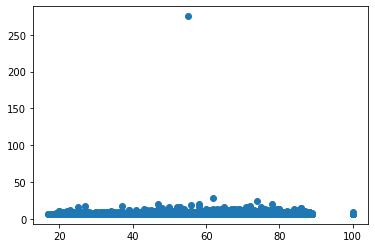

In [152]:
plt.scatter(times['Age'],times['Time_To_Sepsis'])
plt.show()

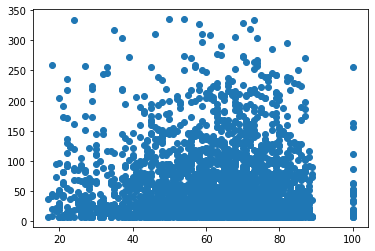

In [153]:
plt.scatter(times['Age'],times['Times_With_Sepsis'])
plt.show()

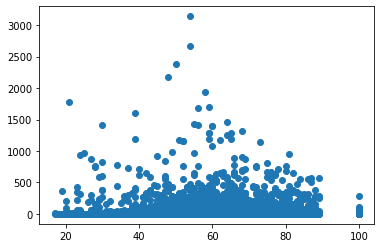

In [155]:
plt.scatter(times['Age'],times['HospAdmit_minus_ICU_admit'])
plt.show()

Great! So there are some interations with sepsis patients and the amount of presence. Lets return to the whole dataset. To wrap my head around this, lets find the patient with the longest time interval, and the least amount of NaNs' lets to these for both sepsis and no sepsis and see their stories. First, lets abs the hosp stay column

In [158]:
sepsis['HospAdmTime'] = np.abs(sepsis['HospAdmTime'].values)

In [174]:
sepsis_patient_ID_by_time = None
max_sepsis_time = 0
non_sepsis_patient_ID_by_time = None
max_non_sepsis_time = 0
for a,b in sepsis.groupby('PatientID'):
    #check for non sepsis frist
    if b['Sepsis_At_All'][0] == 0:
        time = b.shape[0]
        info = (np.sum(pd.isnull(b).values) / (b.shape[0]*b.shape[1]))*100
        if time > max_non_sepsis_time:
            max_non_sepsis_time = time
            non_sepsis_patient_ID_by_time = (a,info)
    elif b['Sepsis_At_All'][0] == 1:
        time = b.shape[0]
        info = (np.sum(pd.isnull(b).values) / (b.shape[0]*b.shape[1]))*100
        if time > max_sepsis_time:
            max_sepsis_time = time
            sepsis_patient_ID_by_time = (a,info)
            
            
            
    

In [179]:
print('Sepsis Patient Example: ',sepsis_patient_ID_by_time,max_sepsis_time)
print('Non-Sepsis Patient Example: ',non_sepsis_patient_ID_by_time,max_non_sepsis_time)

Sepsis Patient Example:  ('p018469', 64.22483766233766) 336
Non-Sepsis Patient Example:  ('p003658', 66.24729437229438) 336


In [183]:
example_sepsis = sepsis[sepsis['PatientID'] == sepsis_patient_ID_by_time[0]]
example_non_sepsis = sepsis[sepsis['PatientID'] == non_sepsis_patient_ID_by_time[0]]

In [191]:
example_sepsis = example_sepsis.fillna(method='bfill').fillna(method='ffill').fillna(0)
example_non_sepsis = example_non_sepsis.fillna(method='bfill').fillna(method='ffill').fillna(0)

In [198]:
#check
np.sum(pd.isnull(example_sepsis).values), np.sum(pd.isnull(example_sepsis).values)

(0, 0)

* yay!! all nans have been taken care of 
* now lets plot these guys with some time series

In [199]:
example_sepsis

PatientID  Delta_t_hours     HR  O2Sat   Temp    SBP    MAP   DBP  Resp  \
0     p018469              0   91.0  100.0  36.78   93.0   52.5  70.0  10.0   
1     p018469              1   91.0  100.0  36.78   93.0   52.5  70.0  10.0   
2     p018469              2   89.0   99.5  36.83   88.5   41.0  70.0   7.5   
3     p018469              3   91.5   99.5  36.00   95.0   58.0  70.0   8.0   
4     p018469              4   91.0   99.0  36.33  103.0   59.5  70.0  10.0   
5     p018469              5   90.0   99.0  36.83   96.0   61.0  70.0  10.0   
6     p018469              6   90.0  100.0  36.83   82.0   56.0  70.0  11.0   
7     p018469              7   94.0  100.0  36.83   86.0   55.0  70.0  11.0   
8     p018469              8   93.0   99.0  36.72   74.0   28.0  70.0   8.0   
9     p018469              9   93.0   99.0  36.72   77.0   41.0  70.0   9.0   
10    p018469             10   98.0   99.0  36.72   78.0   39.0  70.0  18.0   
11    p018469             11   97.0   99.0  36.72   78.0   44.0  70.0  16.0   
12    p018469             12  103.0   99.0  37.78   87.0   47.0  70.0  15.0   
13    p018469             13  109.0   99.0  37.78   87.0   73.0  70.0  17.0   
14    p018469             14  105.0   99.0  37.78   78.0   54.0  70.0  15.0   
15    p018469             15  108.0   99.0  38.61   80.0   52.0  70.0  14.0   
16    p018469             16  109.0   99.0  38.61   83.0   45.0  70.0   8.0   
17    p018469             17  109.0   99.0  38.61   80.0   41.0  70.0  11.0   
18    p018469             18  115.0   97.0  38.61   83.0   40.0  70.0  18.0   
19    p018469             19  115.0   97.0  38.61   83.0   40.0  70.0  18.0   
20    p018469             20  115.0   97.0  38.61   80.0   56.0  70.0  15.0   
21    p018469             21  109.0   97.0  38.17   80.0   47.0  70.0  10.0   
22    p018469             22  112.0   97.0  38.17   78.0   48.0  70.0  15.0   
23    p018469             23  112.5   97.0  38.33   69.5   35.0  70.0  13.0   
24    p018469             24  107.0  100.0  38.17   66.0   32.0  70.0  12.0   
25    p018469             25  109.0  100.0  38.17   72.0   36.0  70.0  12.0   
26    p018469             26  104.0  100.0  38.00   72.0   44.0  70.0  10.0   
27    p018469             27  107.0  100.0  38.00   77.0   45.0  70.0  10.0   
28    p018469             28  107.0  100.0  38.00   78.0   36.0  70.0  19.0   
29    p018469             29  107.0  100.0  38.00   77.0   39.0  70.0  18.0   
30    p018469             30  101.0  100.0  37.72   79.0   31.0  70.0  10.0   
31    p018469             31  102.5  100.0  37.72   71.5   52.0  70.0  15.0   
32    p018469             32  105.0  100.0  37.61   76.0   54.0  70.0   8.0   
33    p018469             33  104.0  100.0  37.61   74.0   54.0  70.0  10.0   
34    p018469             34  107.0  100.0  37.61   80.0   41.0  70.0   8.0   
35    p018469             35  104.0  100.0  37.61   71.0   51.0  70.0  10.0   
36    p018469             36  105.0  100.0  37.83   67.0   51.0  70.0   9.0   
37    p018469             37  106.0  100.0  37.83   78.0   60.0  70.0  10.0   
38    p018469             38  103.0  100.0  37.83   88.0   61.0  70.0   8.0   
39    p018469             39  106.0  100.0  37.83   81.0   59.0  70.0   9.0   
40    p018469             40  107.0  100.0  37.72   73.0   54.0  70.0  16.0   
41    p018469             41  106.0  100.0  37.72   74.0   54.0  70.0  16.0   
42    p018469             42  105.0  100.0  37.72   76.0   53.0  70.0  16.0   
43    p018469             43  105.0  100.0  37.72   76.0   53.0  70.0  16.0   
44    p018469             44  104.0  100.0  37.44   75.0   54.0  70.0  19.0   
45    p018469             45  102.0  100.0  37.44   78.0   56.0  70.0  17.0   
46    p018469             46  105.0  100.0  37.44   74.0   54.0  70.0  13.0   
47    p018469             47  105.0  100.0  37.44   74.0   54.0  70.0  13.0   
48    p018469             48  109.0  100.0  37.44   92.0   65.0  70.0   9.0   
49    p018469             49  110.0  100.0  37.44   83

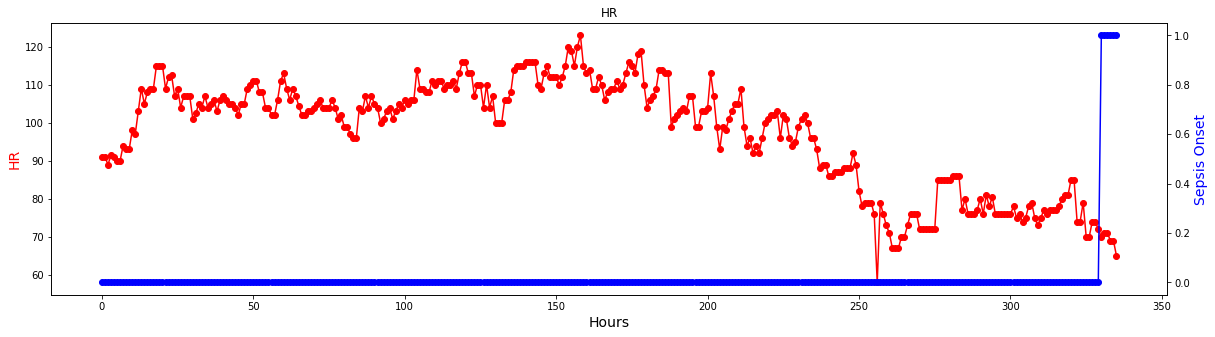

In [219]:
def plot_sepsis_covariates(col_name,data,col1,col2):
    #create the above plot a colname
    fig,ax = plt.subplots(figsize=(20, 5))
    # make a plot
    ax.plot(data['Delta_t_hours'], data[col_name], color=col1, marker="o")
    # set x-axis label
    ax.set_xlabel("Hours",fontsize=14)
    # set y-axis label
    ax.set_ylabel(col_name,color="red",fontsize=14)
    # twin object for two different y-axis on the sample plot
    ax2=ax.twinx()
    # make a plot with different y-axis using second axis object
    ax2.plot(data['Delta_t_hours'], data['SepsisLabel'],color=col2,marker="o")
    ax2.set_ylabel("Sepsis Onset",color="blue",fontsize=14)
    plt.title(col_name)
    plt.show()
plot_sepsis_covariates('HR',example_sepsis,'red','blue')


    

Now loop through out indicators to get an idea for this patient!

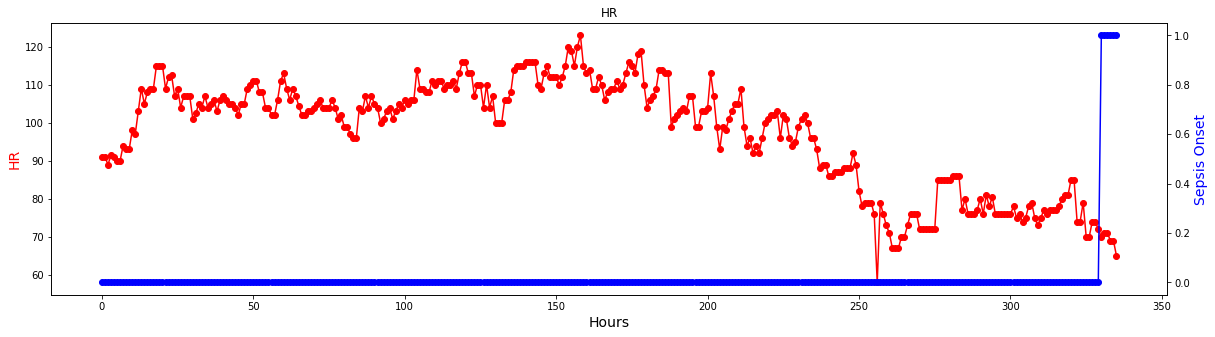

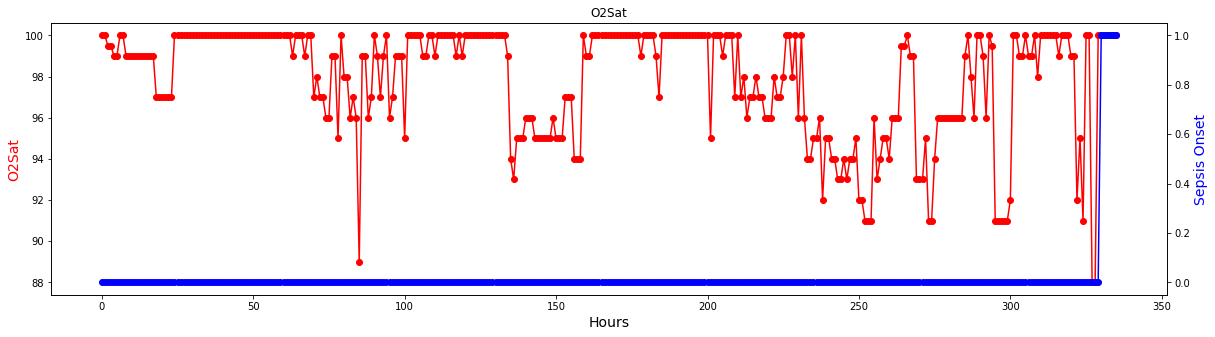

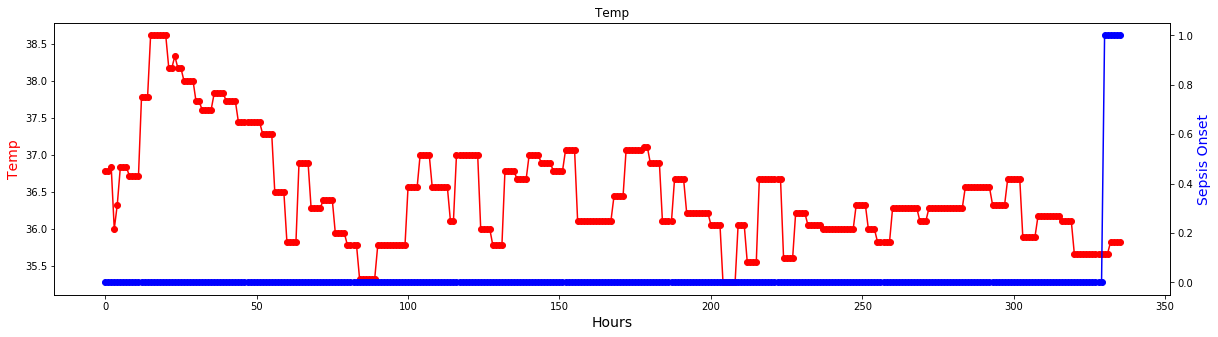

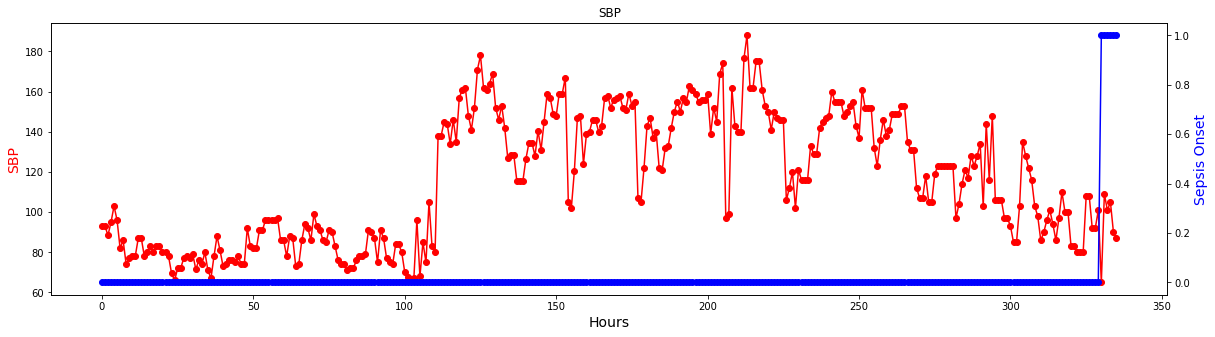

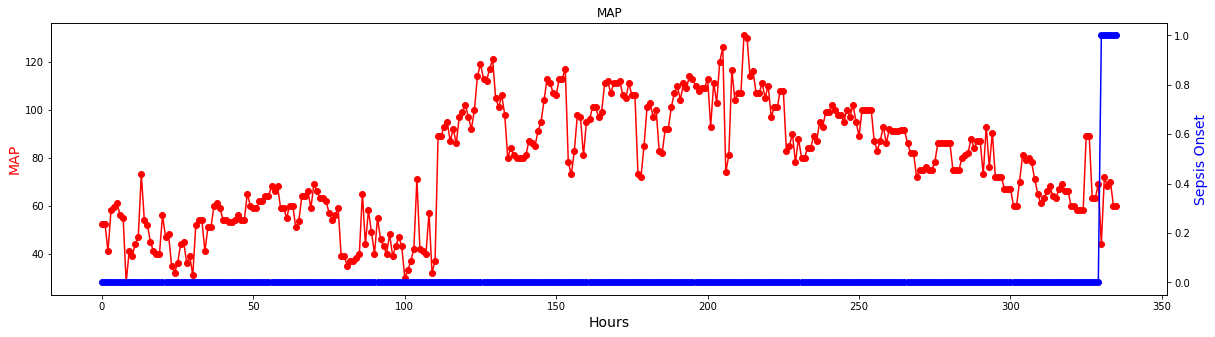

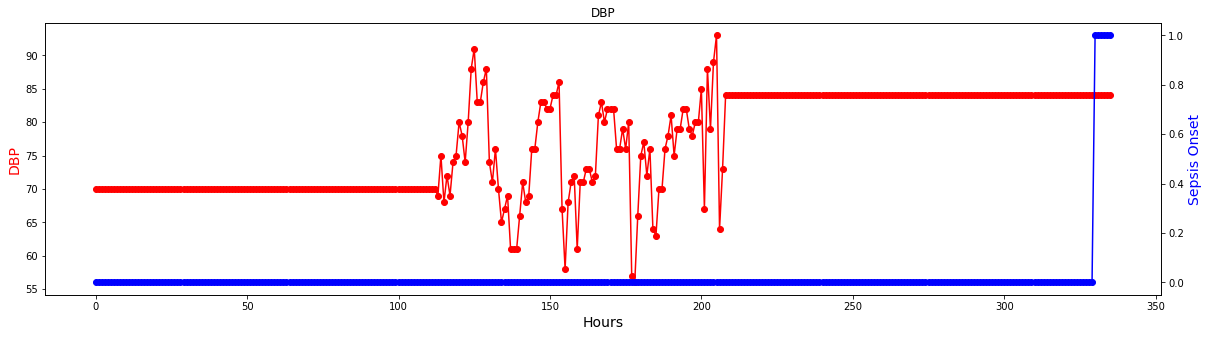

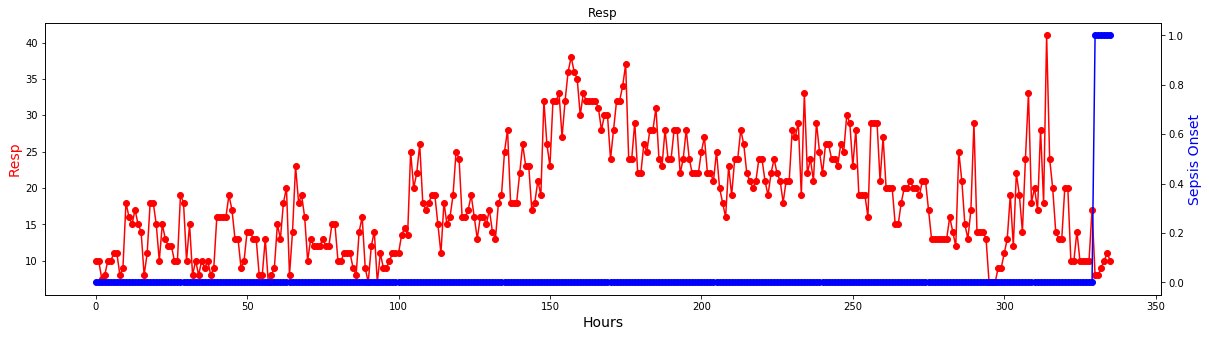

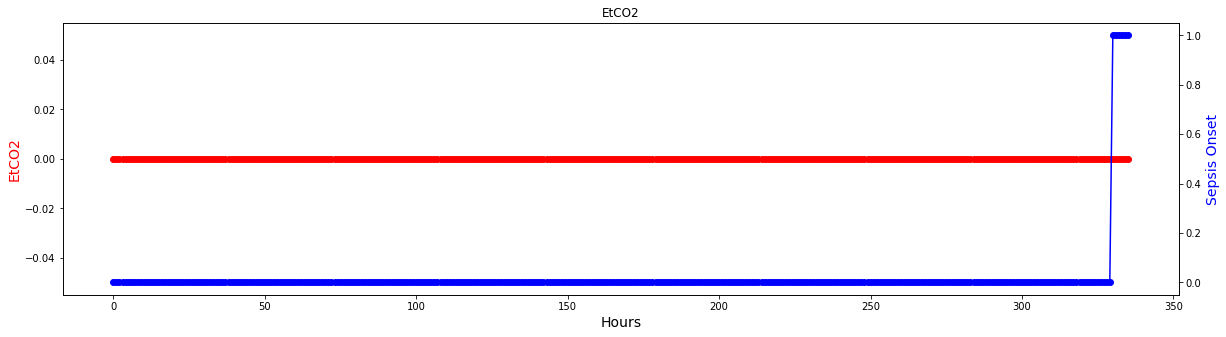

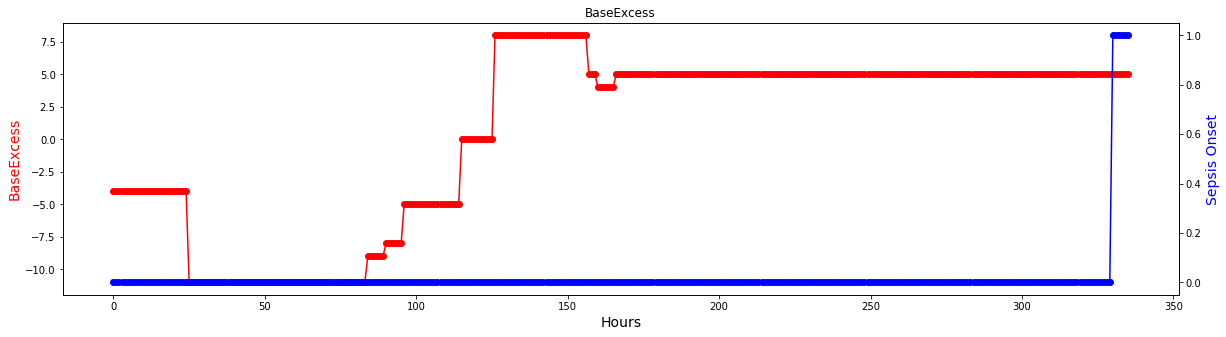

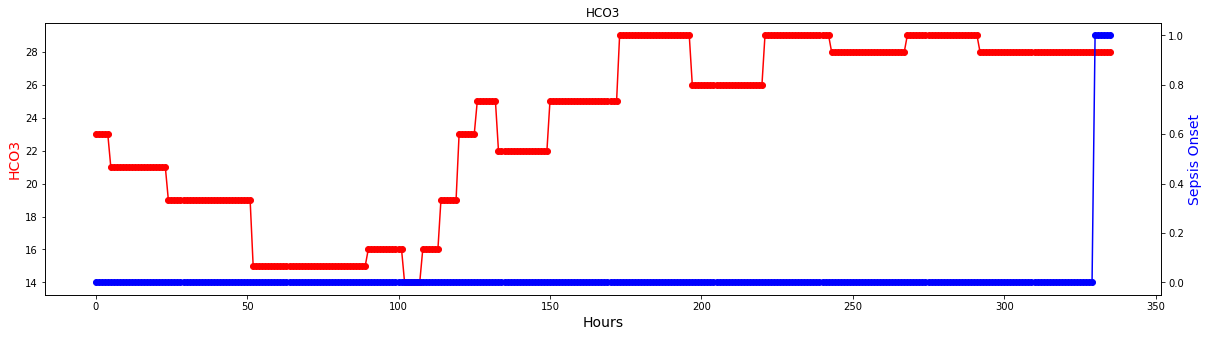

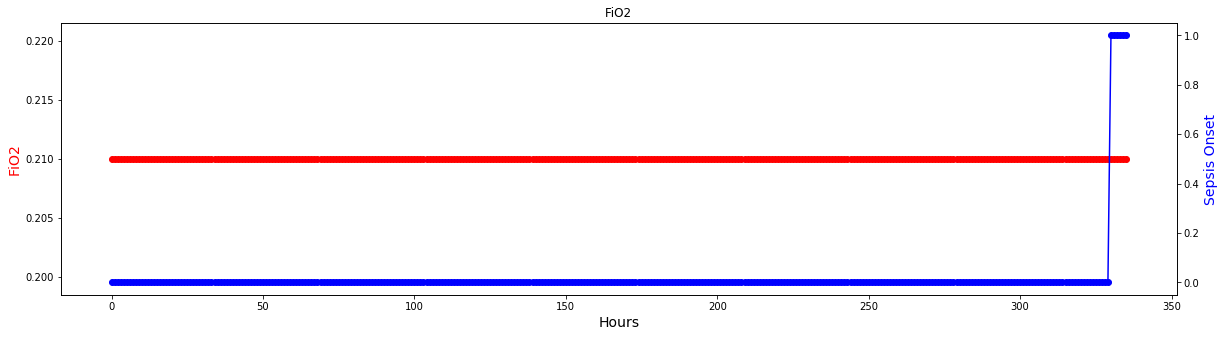

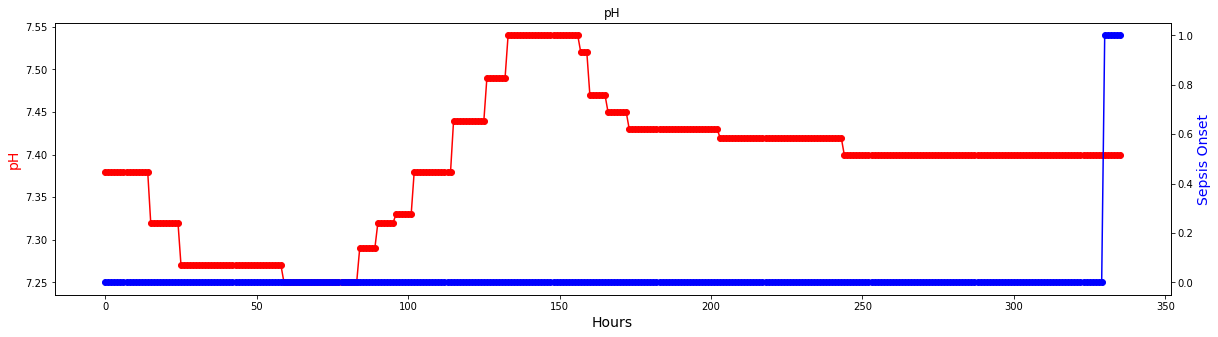

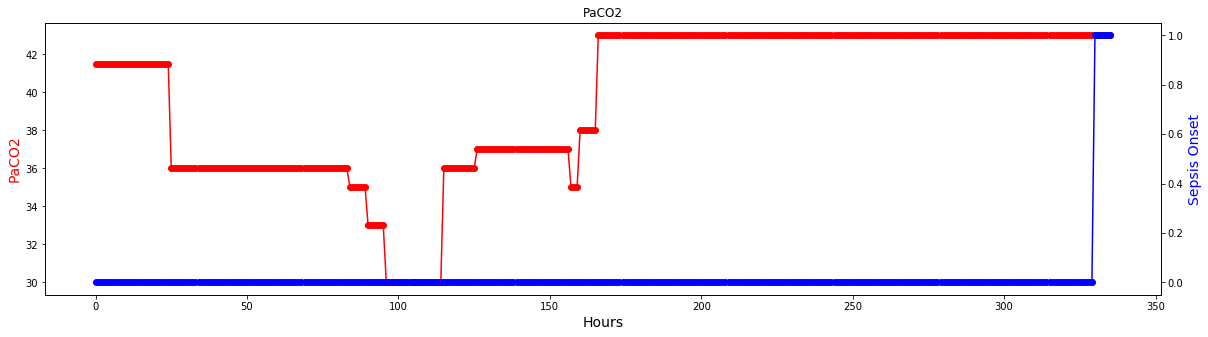

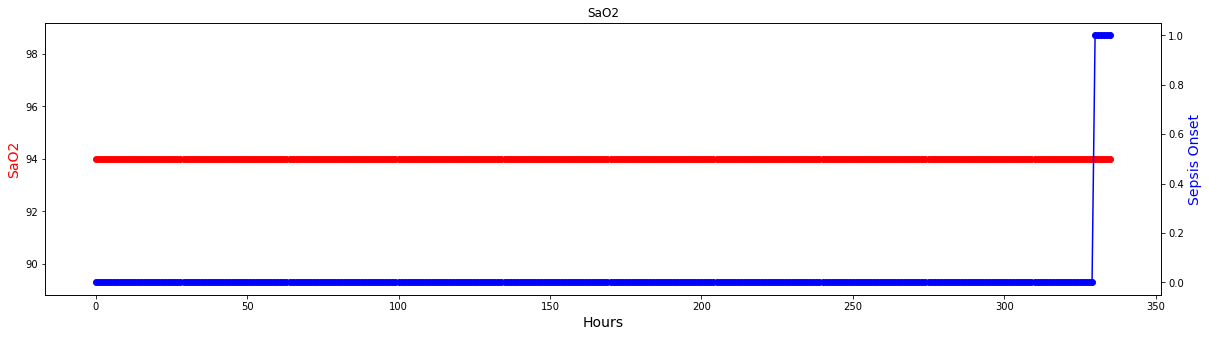

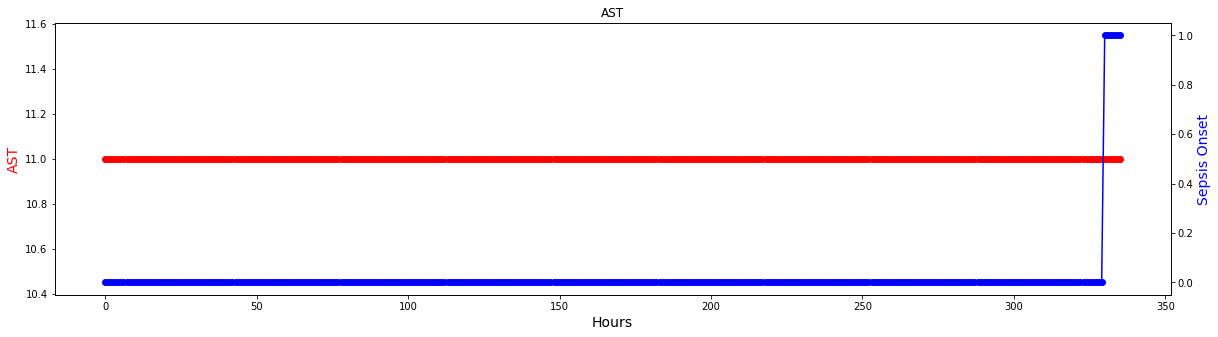

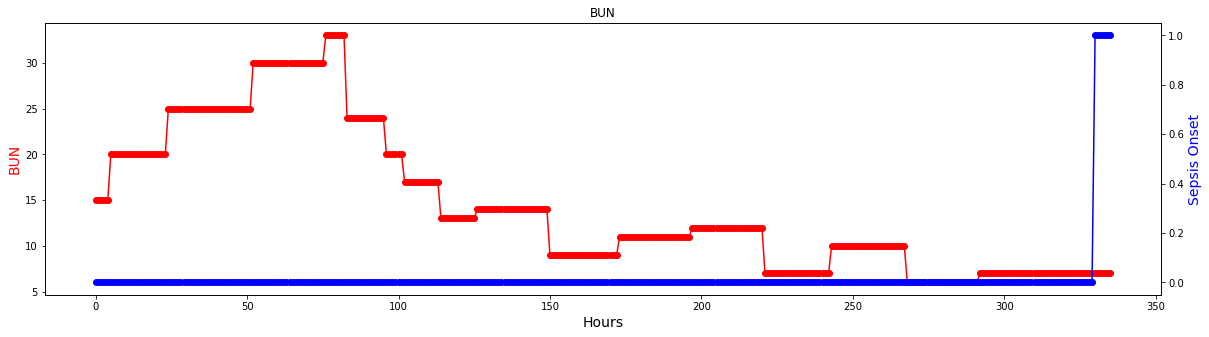

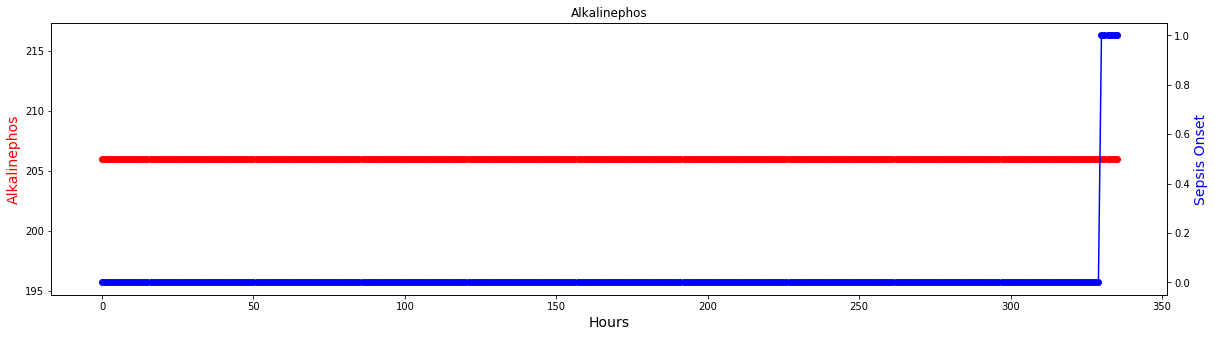

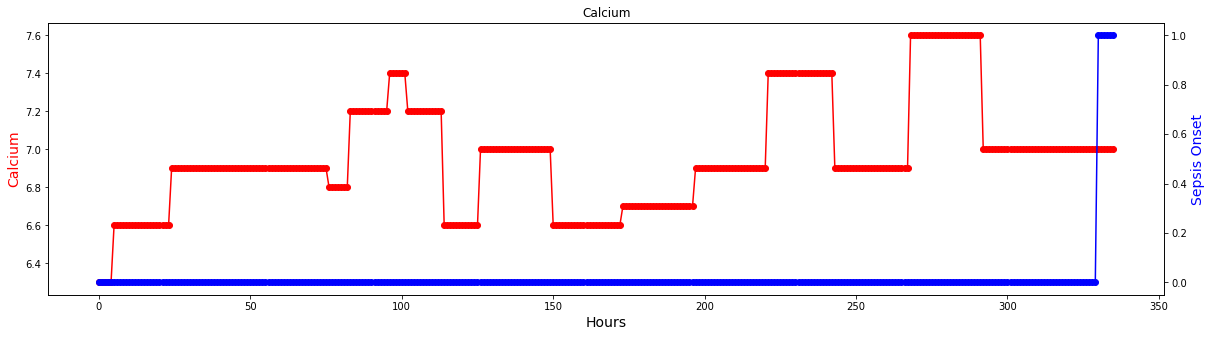

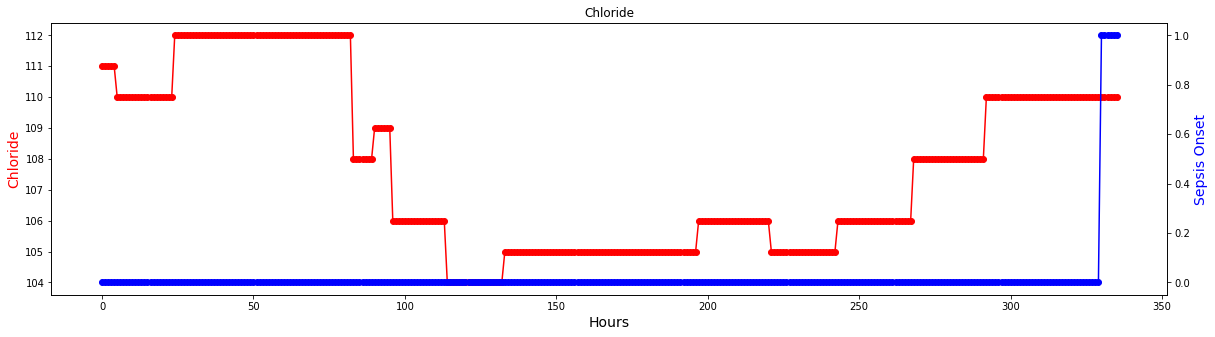

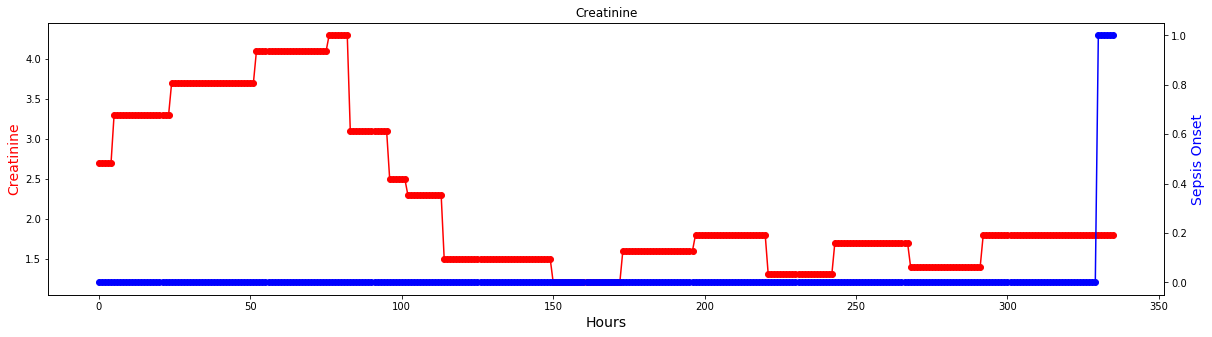

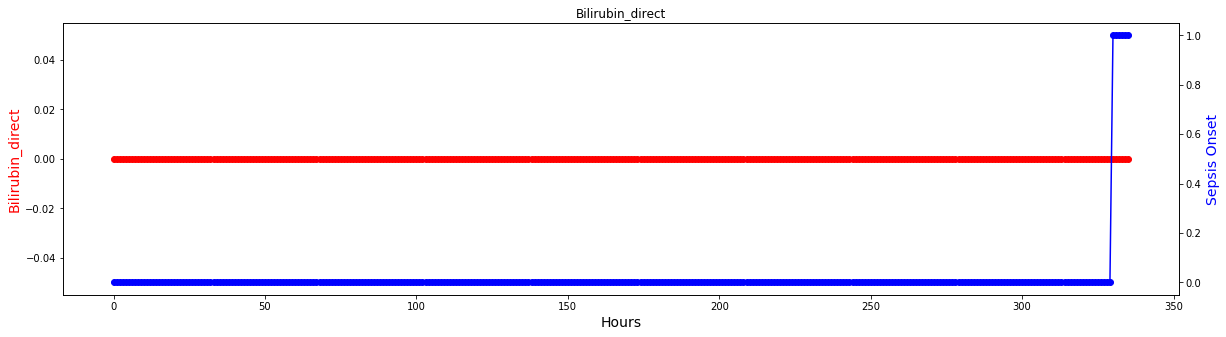

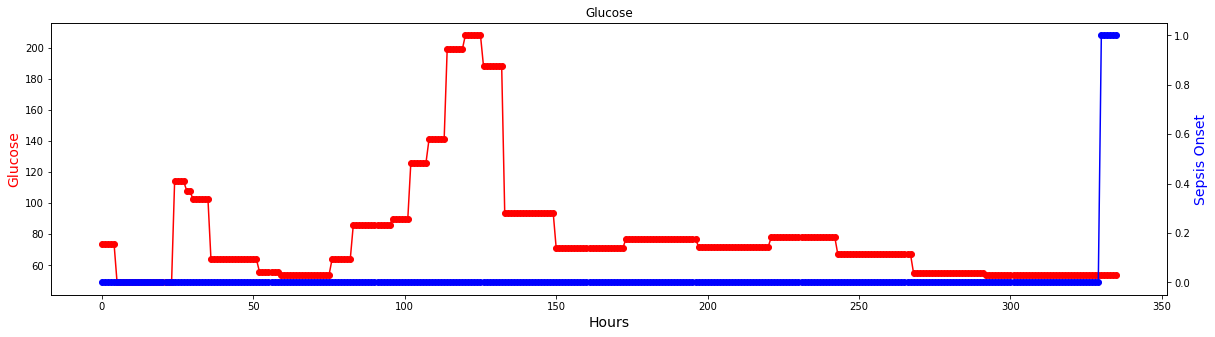

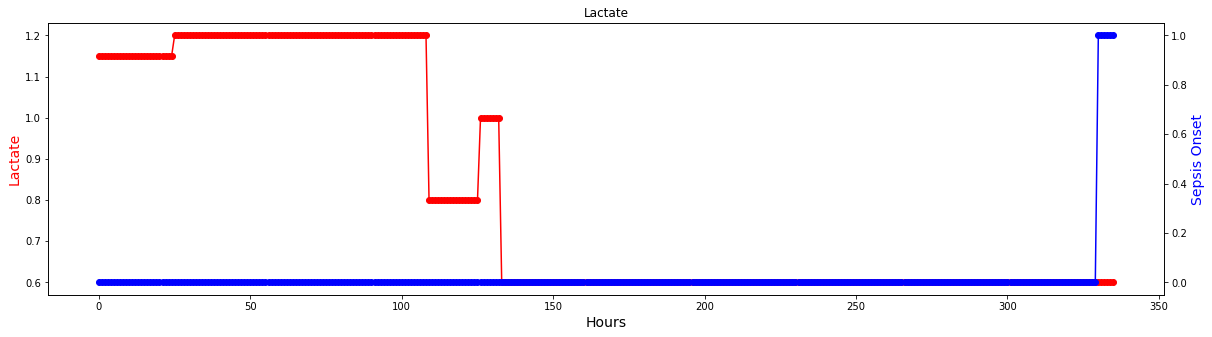

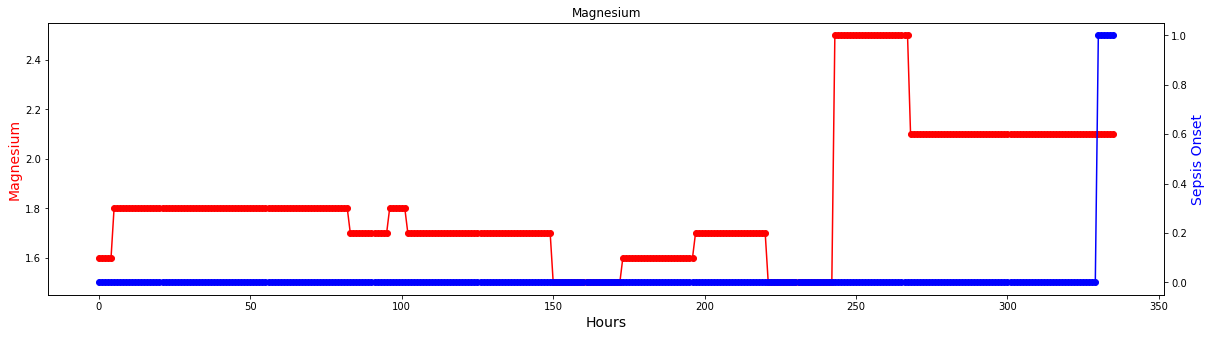

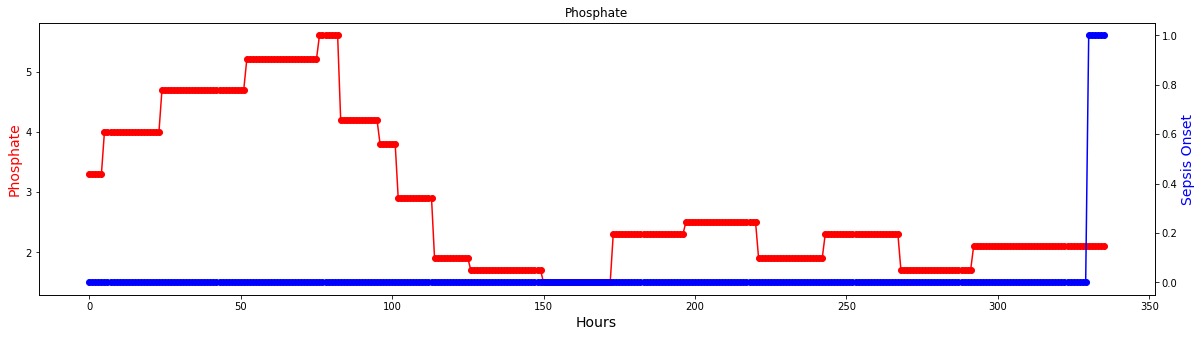

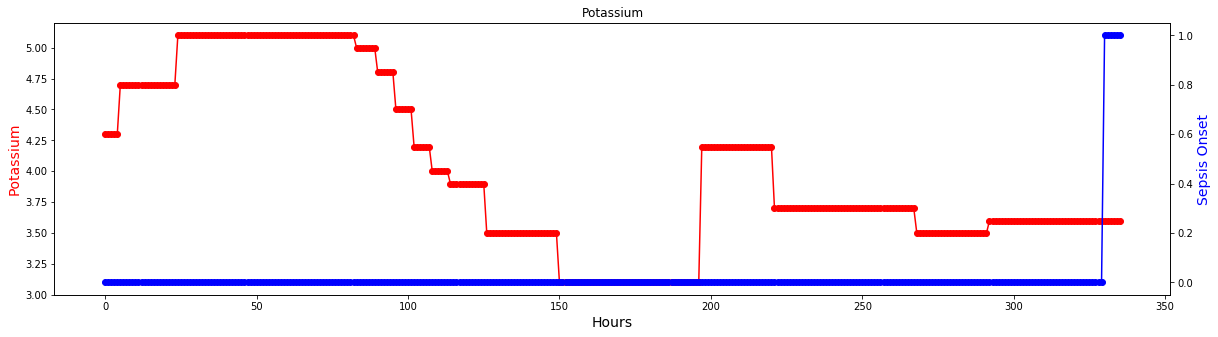

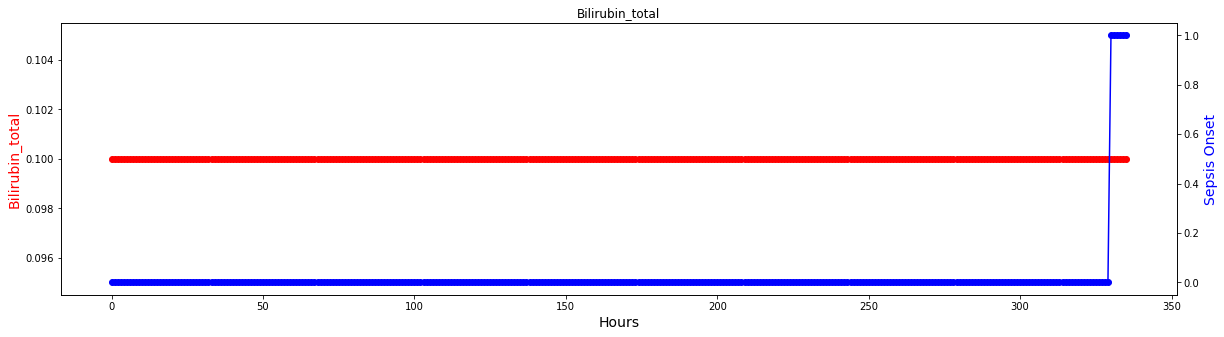

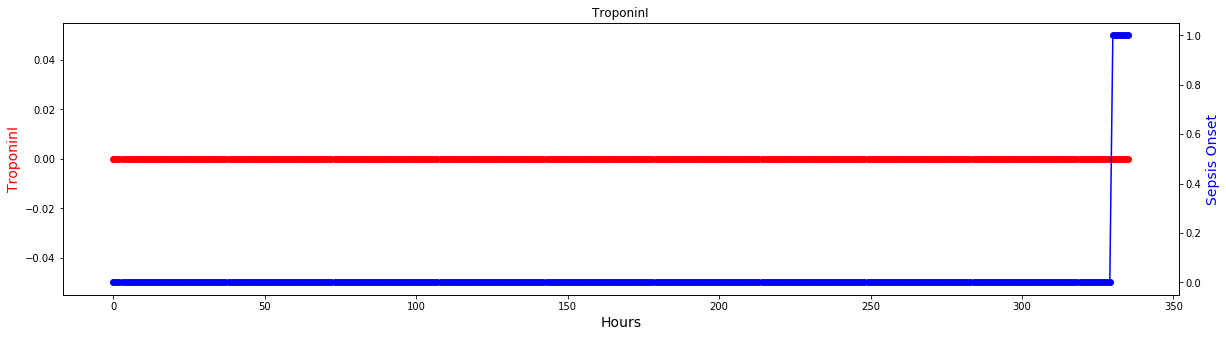

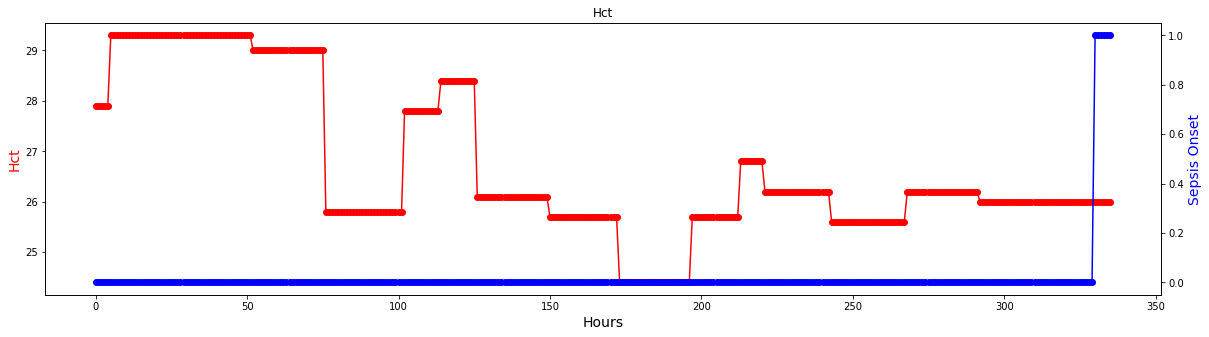

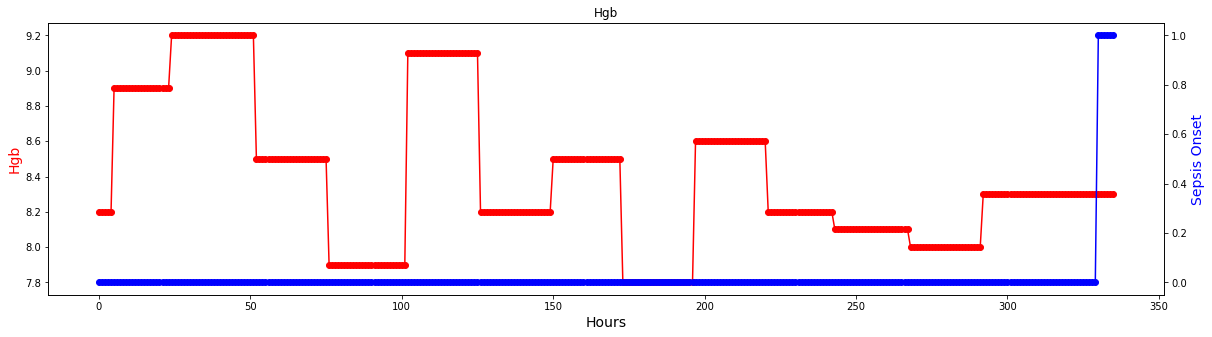

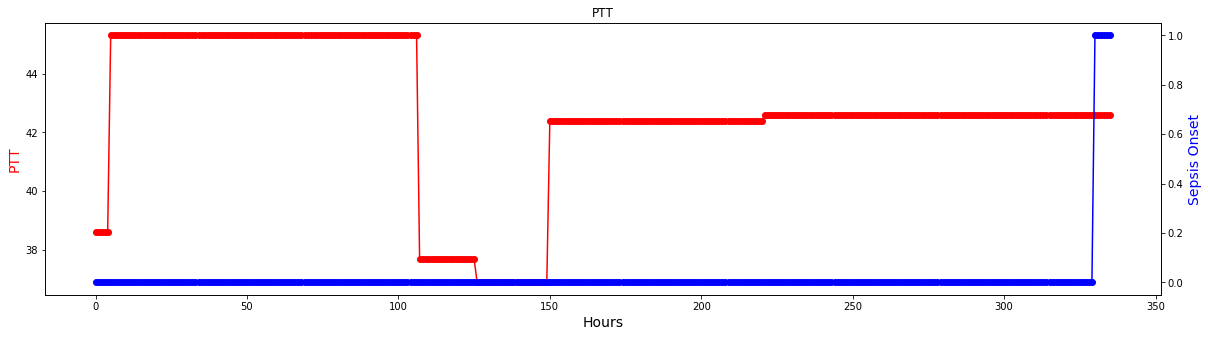

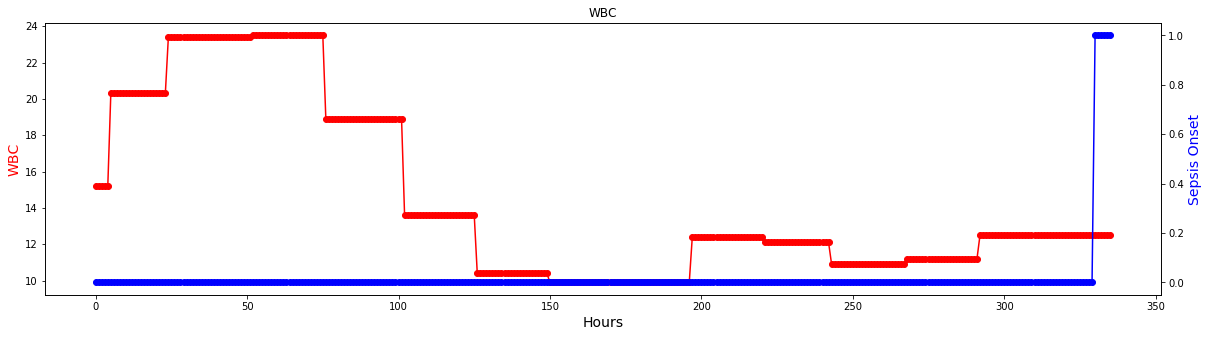

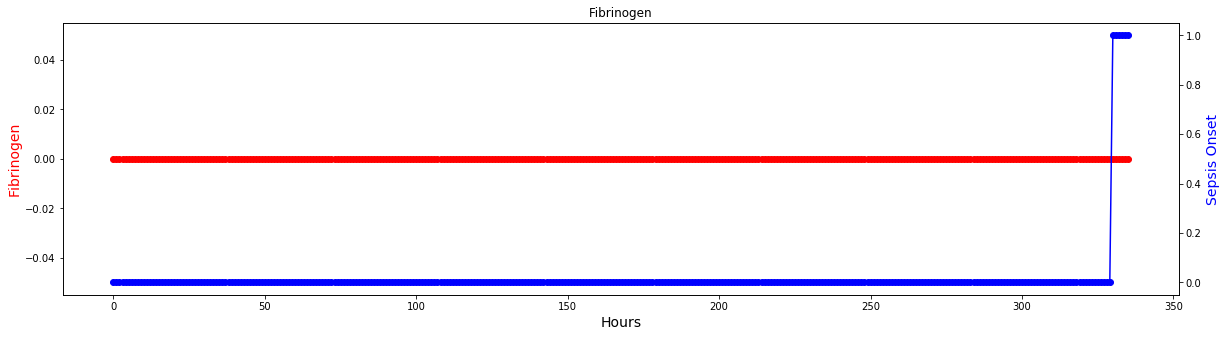

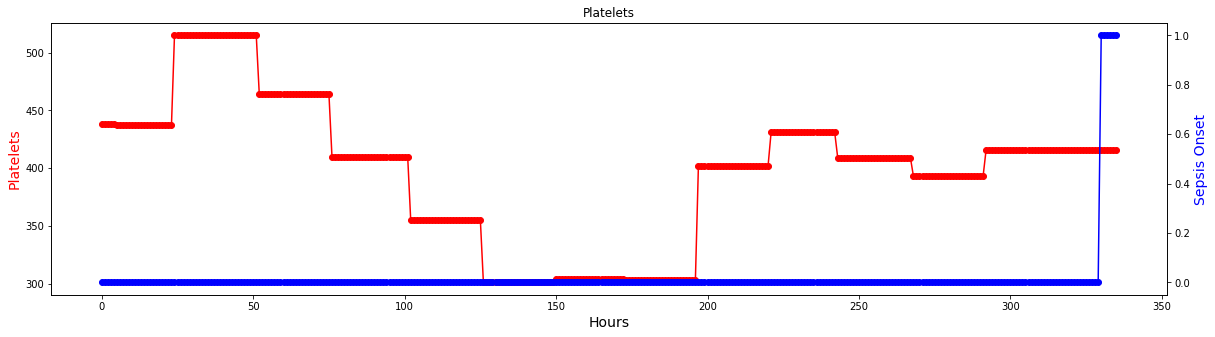

In [220]:
indicators = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP',
       'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2',
       'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride',
       'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium',
       'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb',
       'PTT', 'WBC', 'Fibrinogen', 'Platelets']
for foo in indicators:
    plot_sepsis_covariates(foo,example_sepsis,'red','blue')

Now do it with non-sepsis

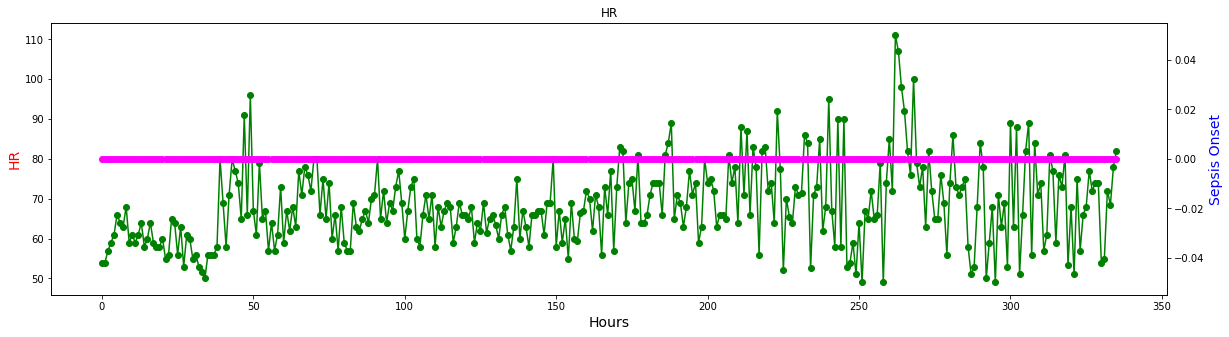

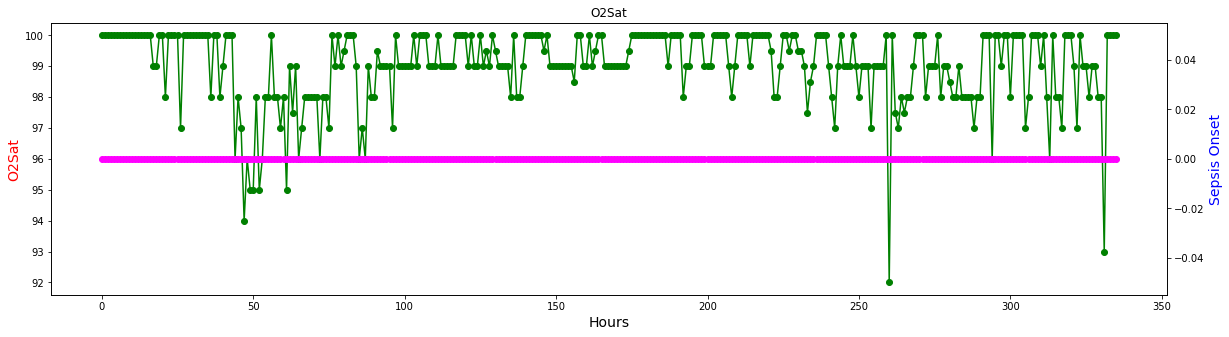

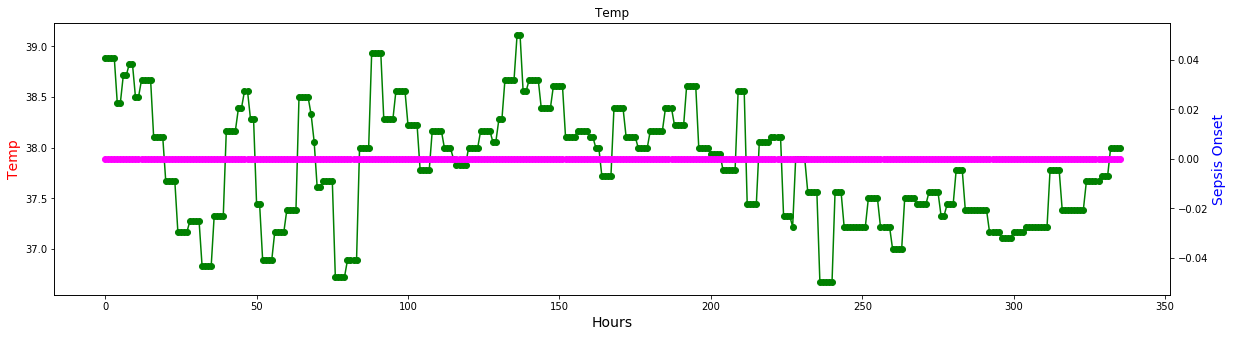

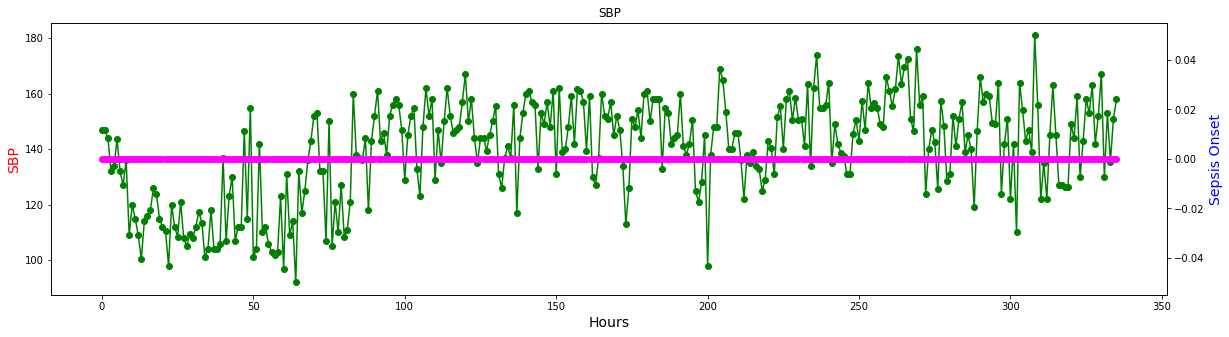

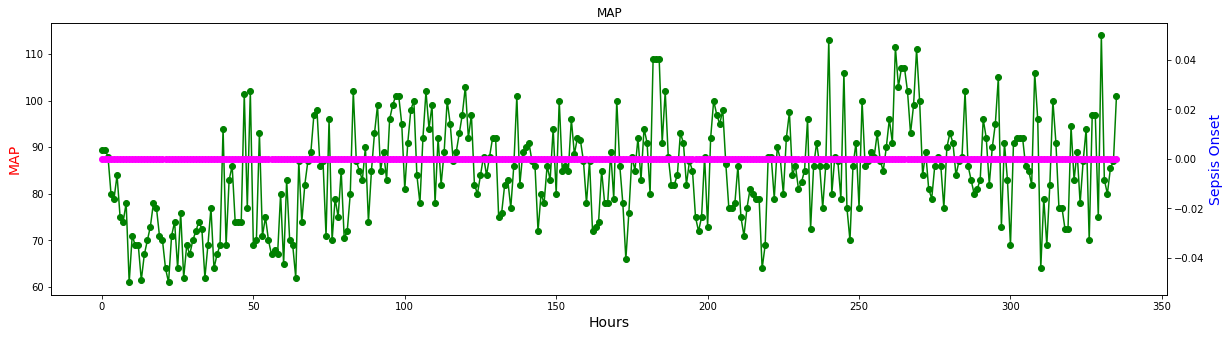

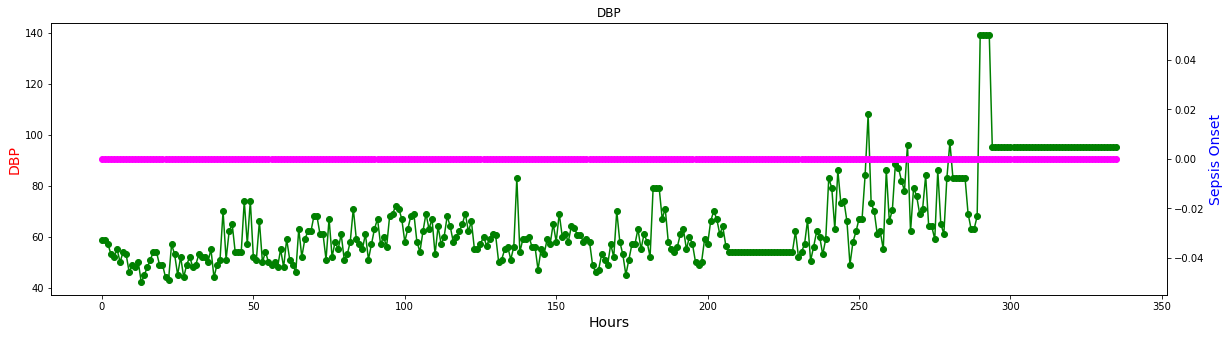

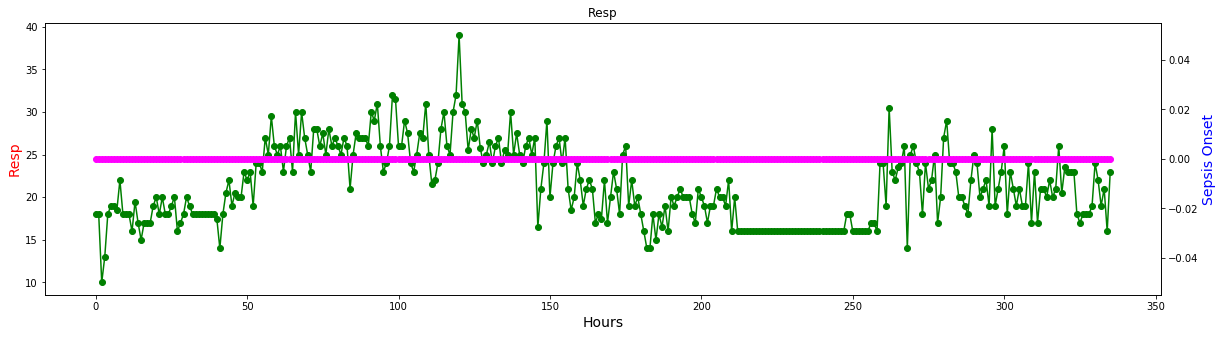

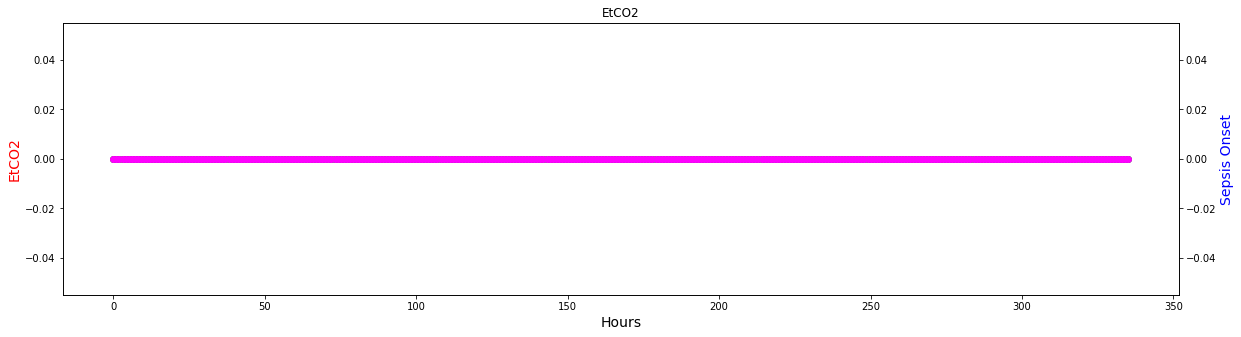

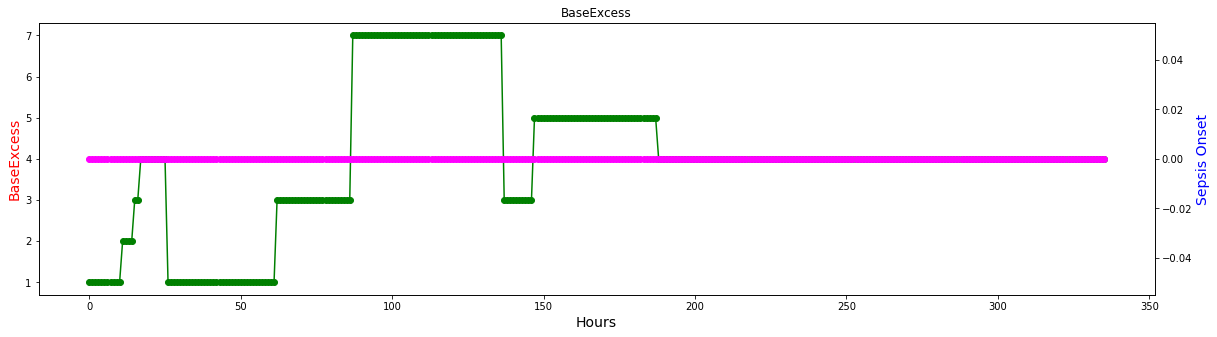

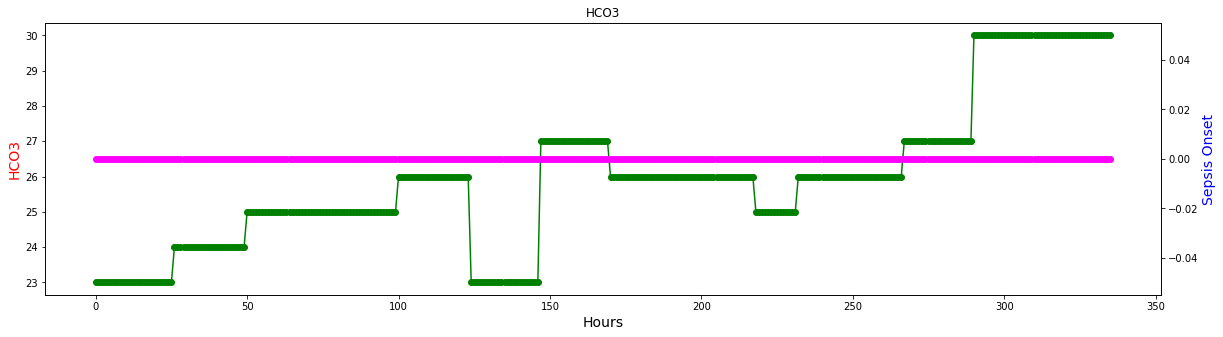

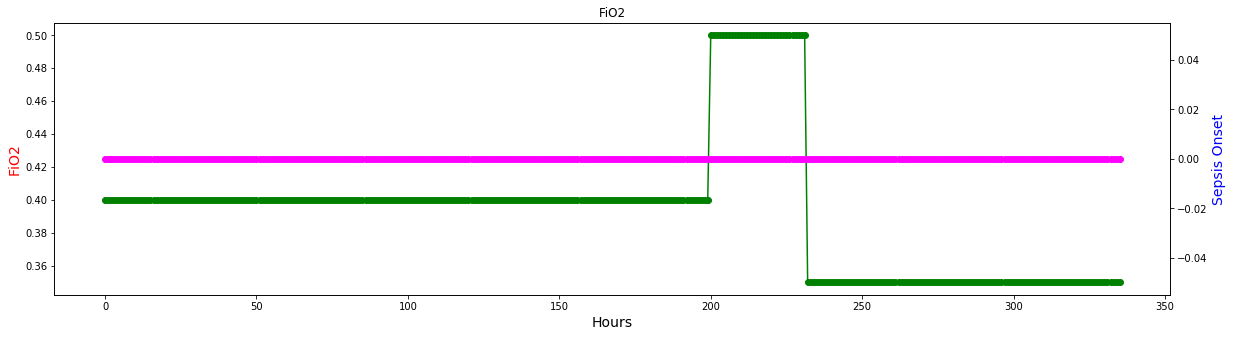

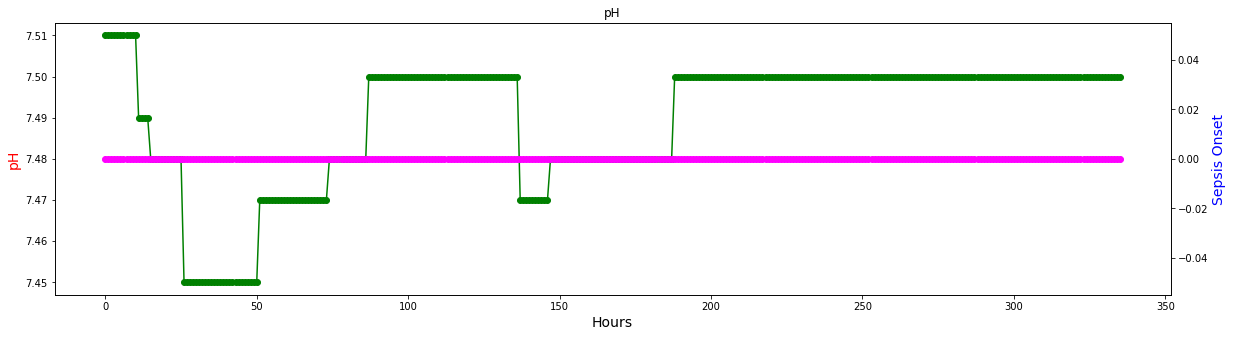

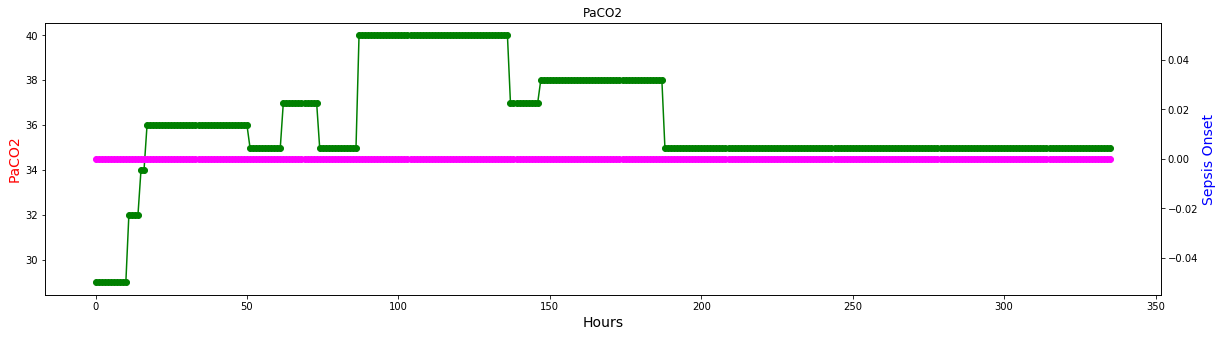

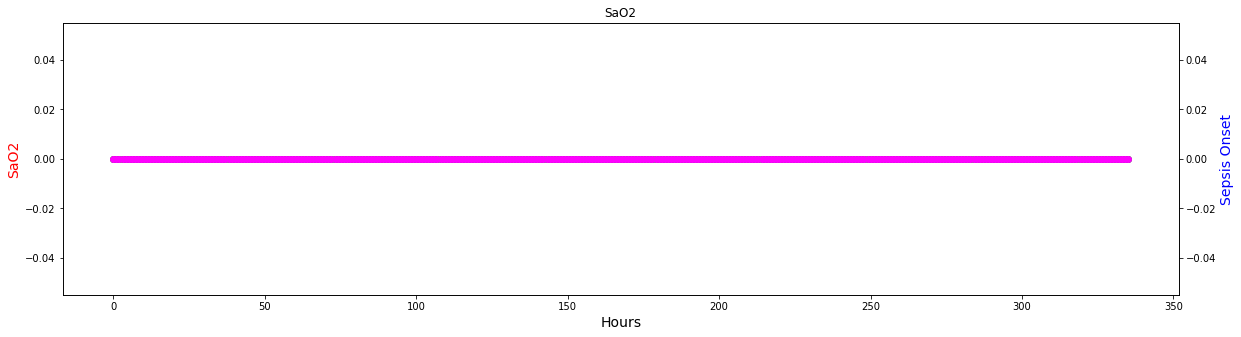

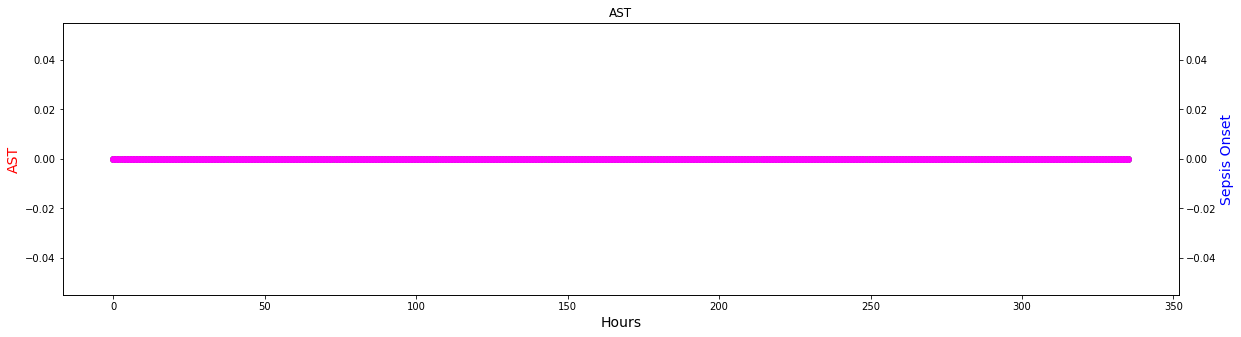

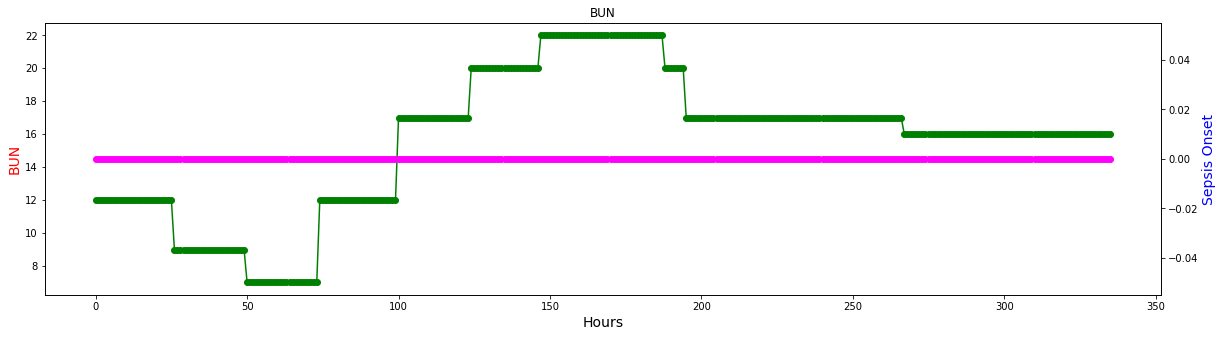

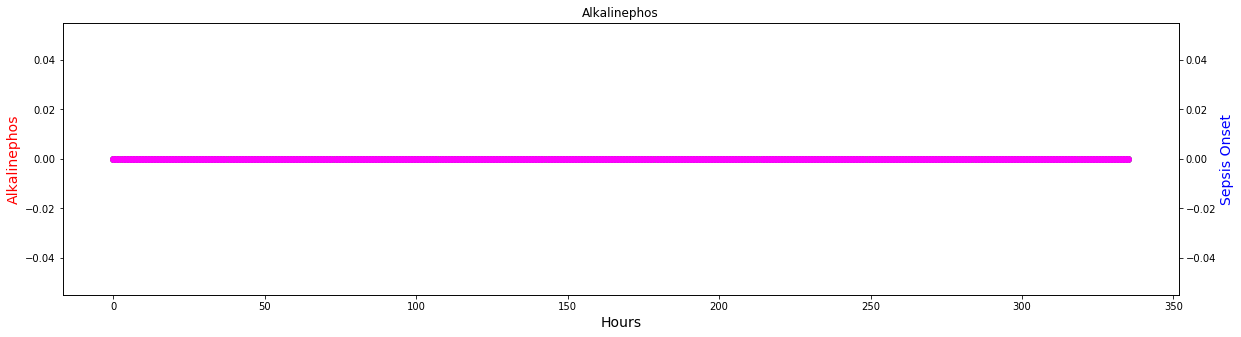

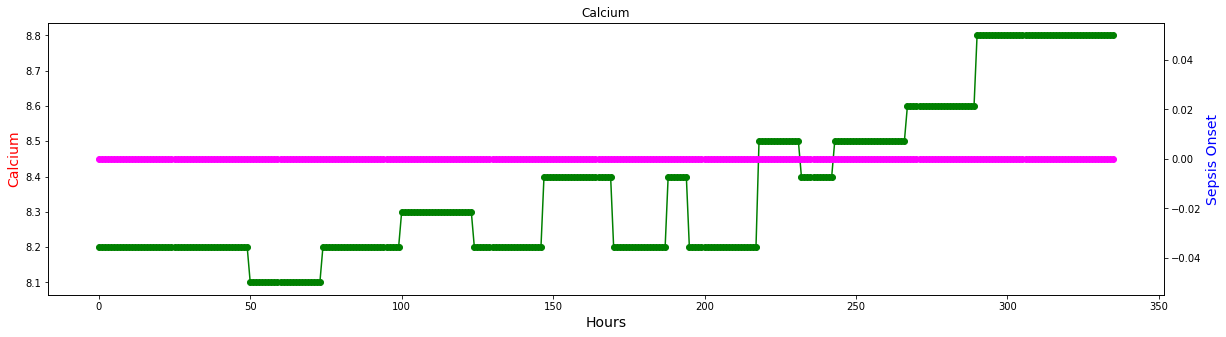

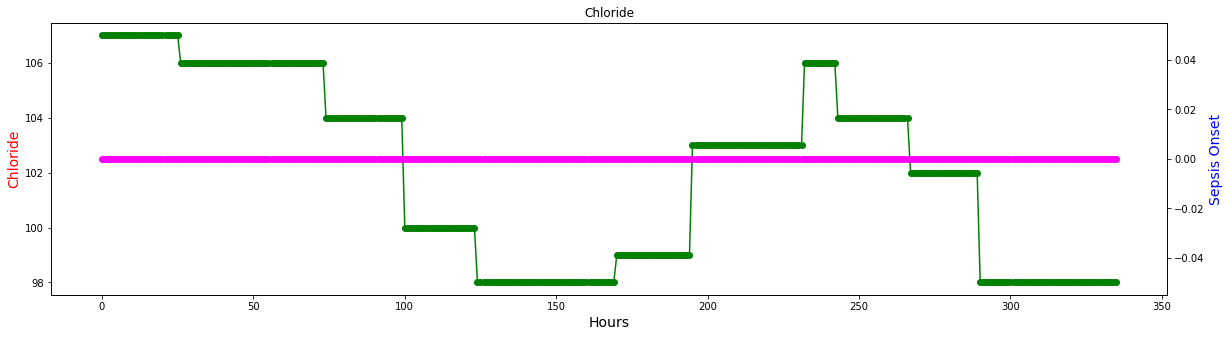

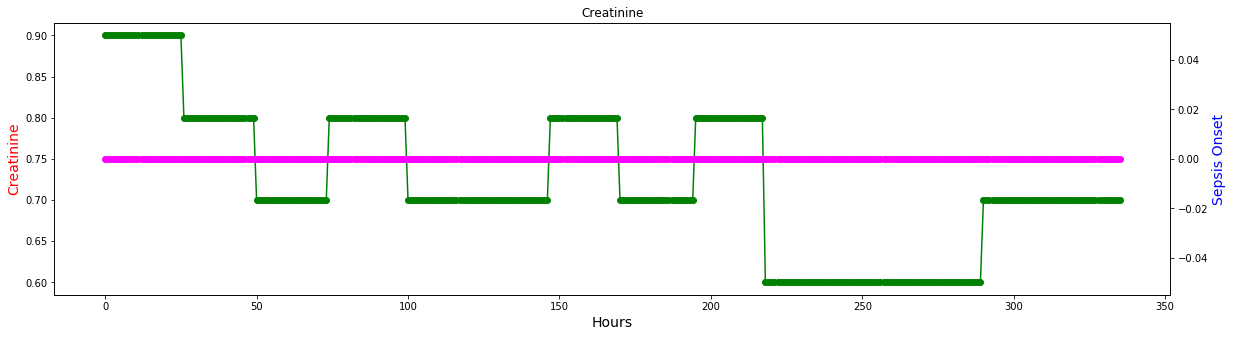

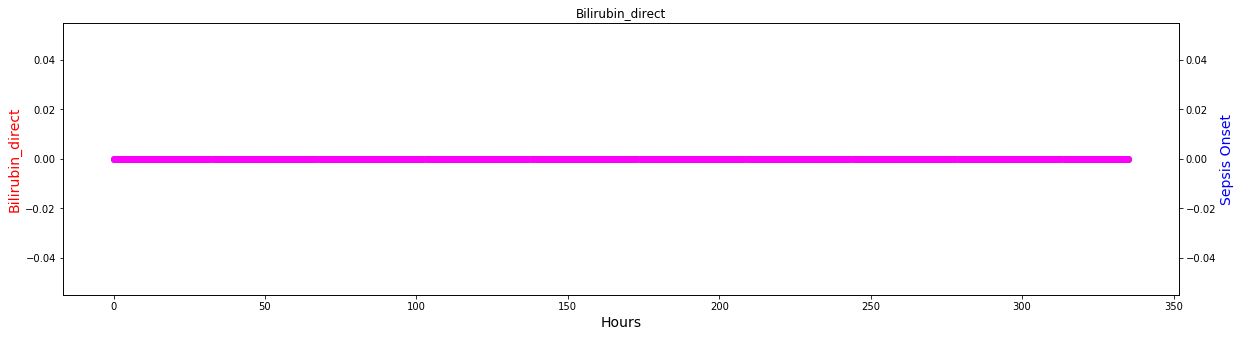

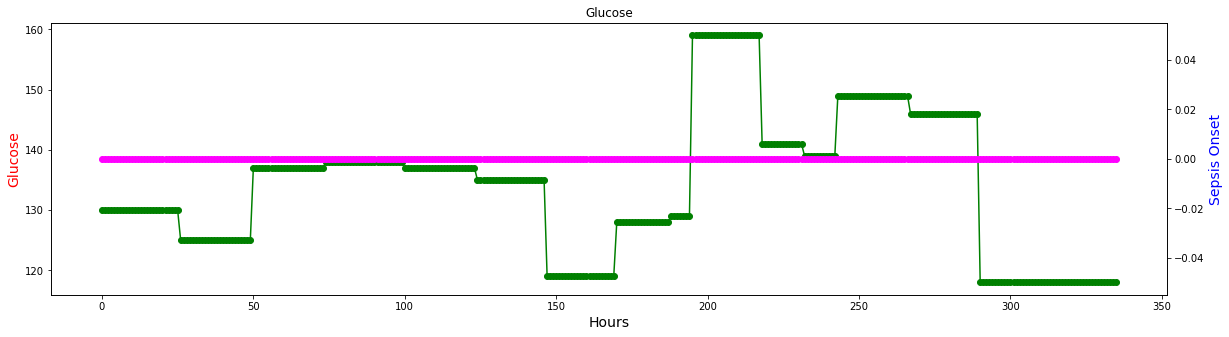

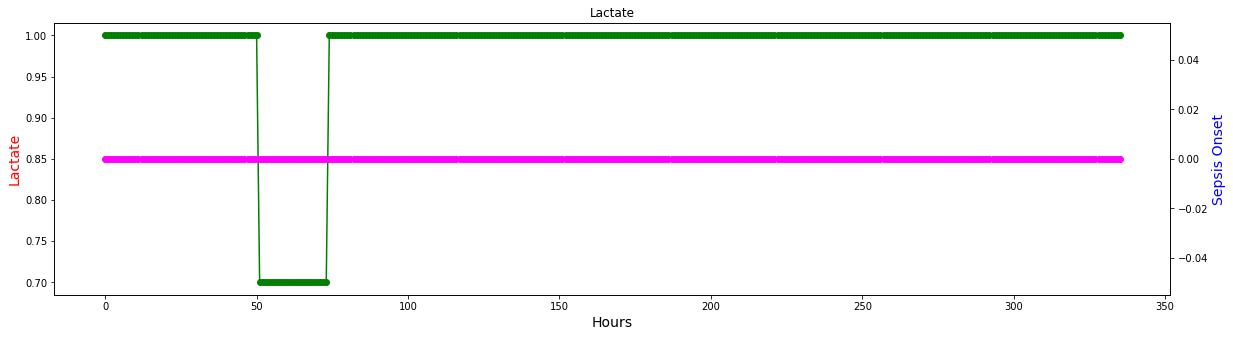

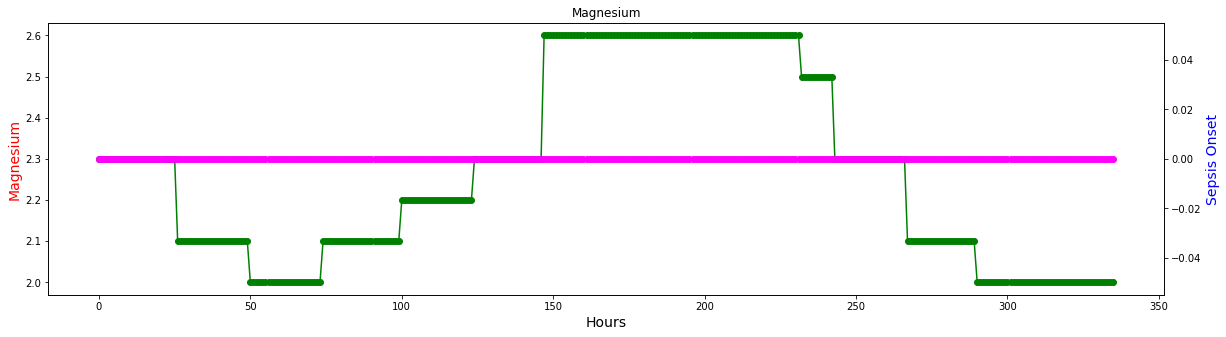

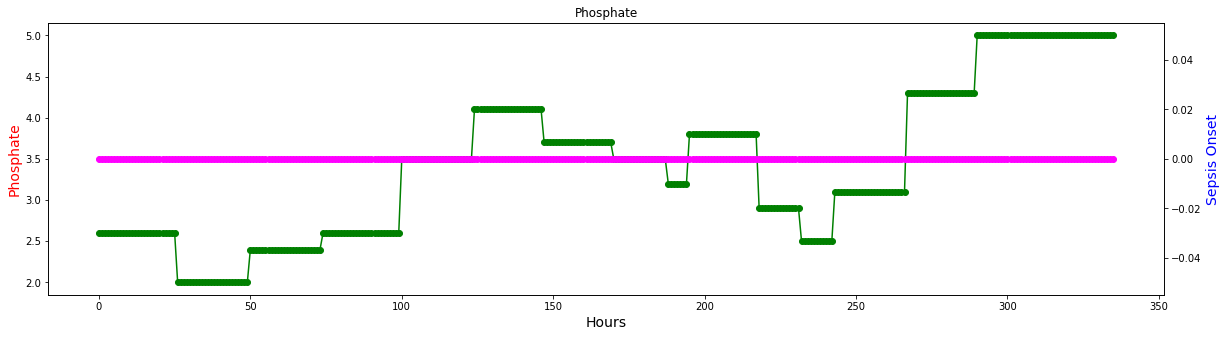

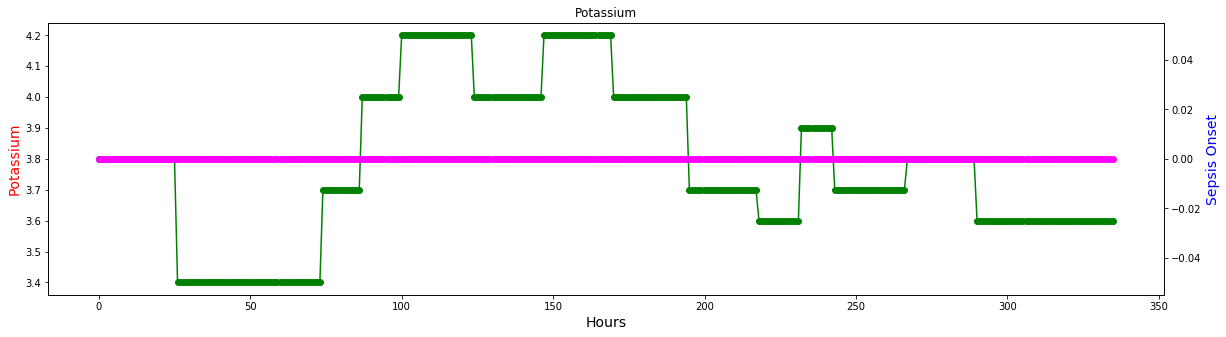

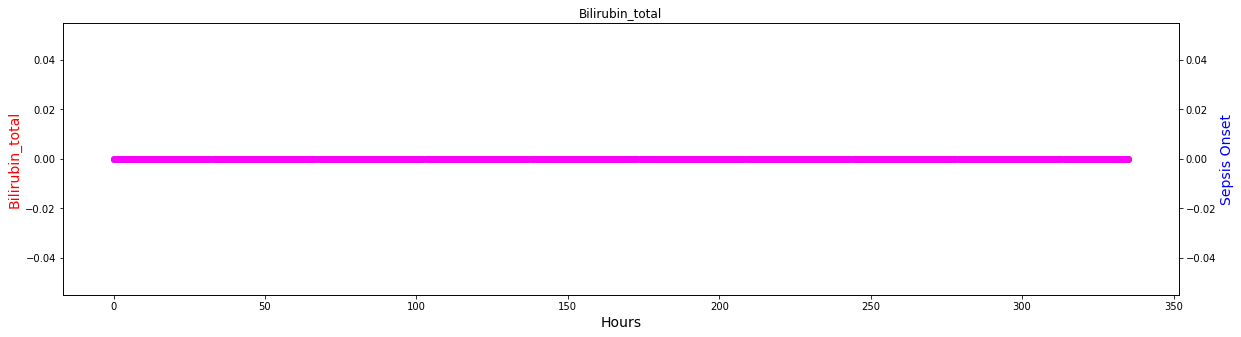

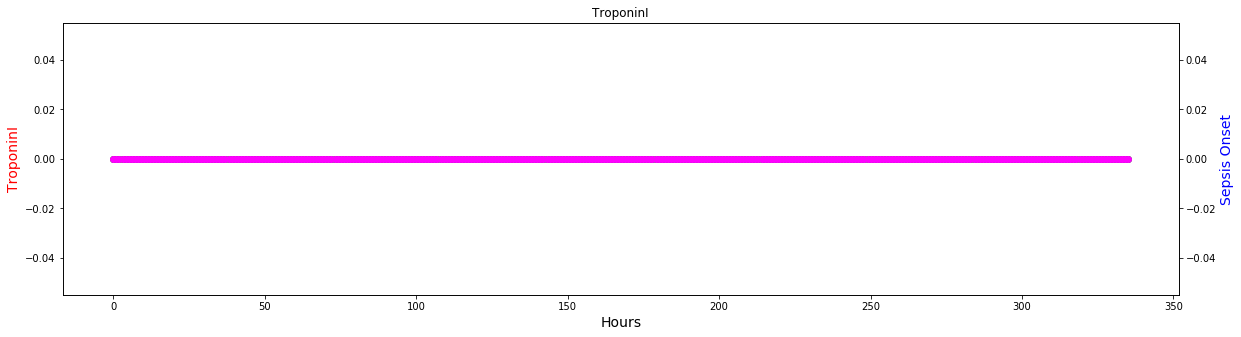

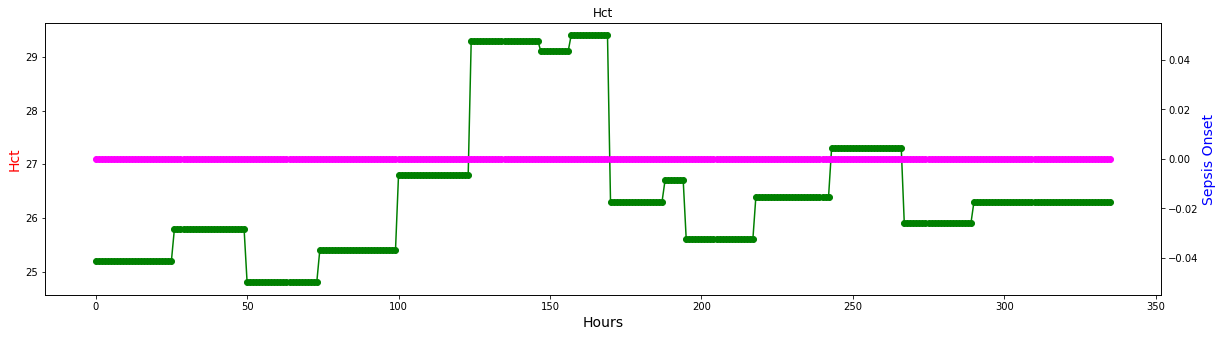

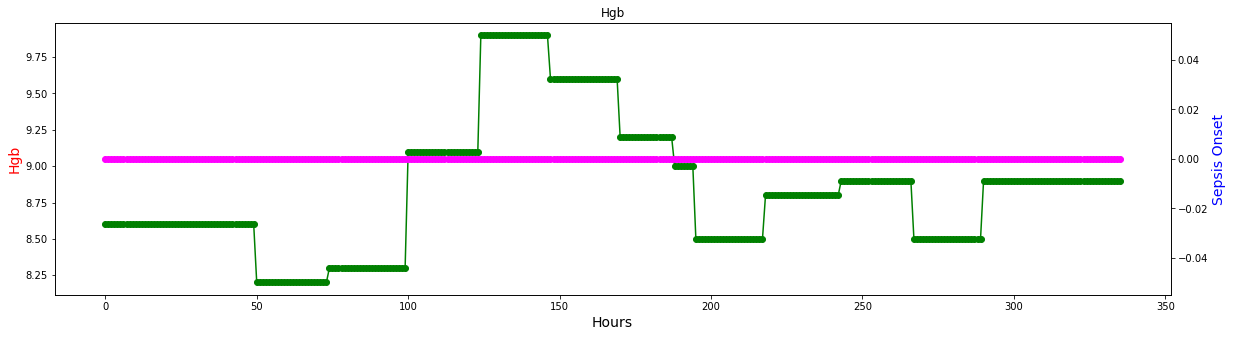

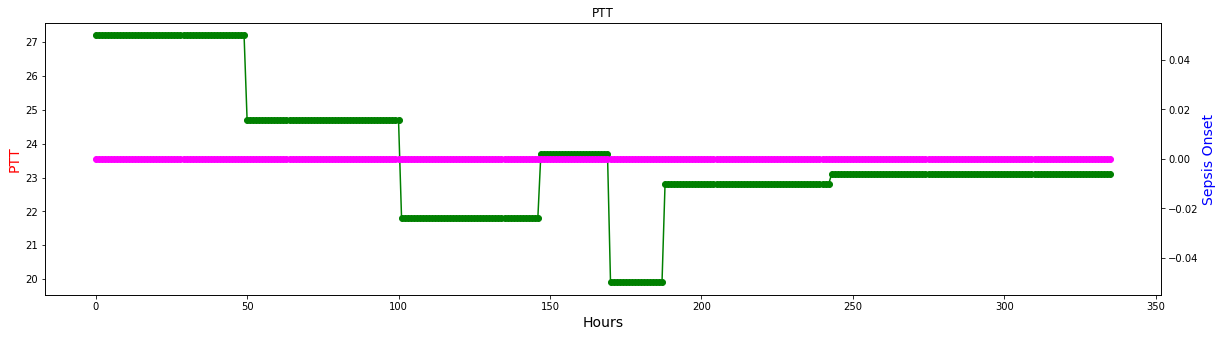

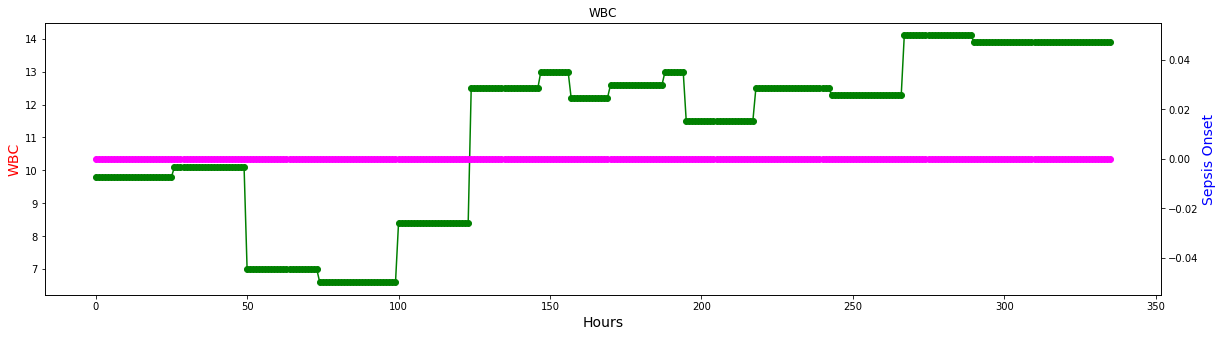

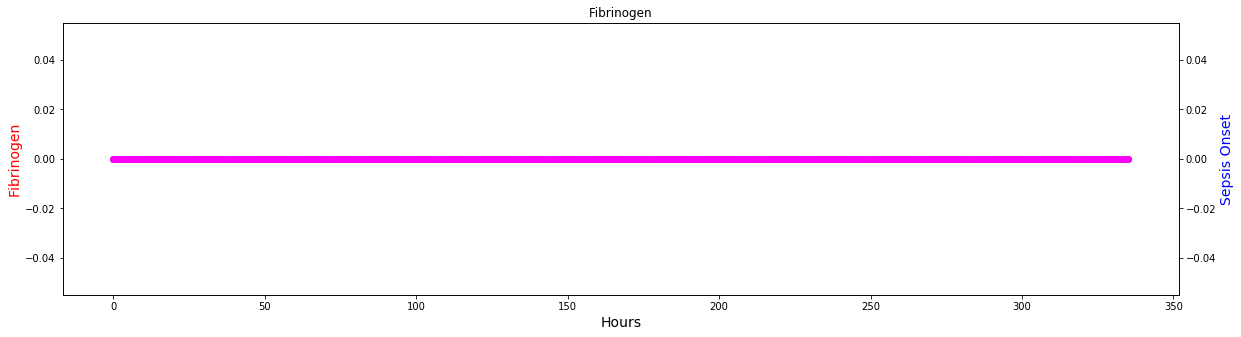

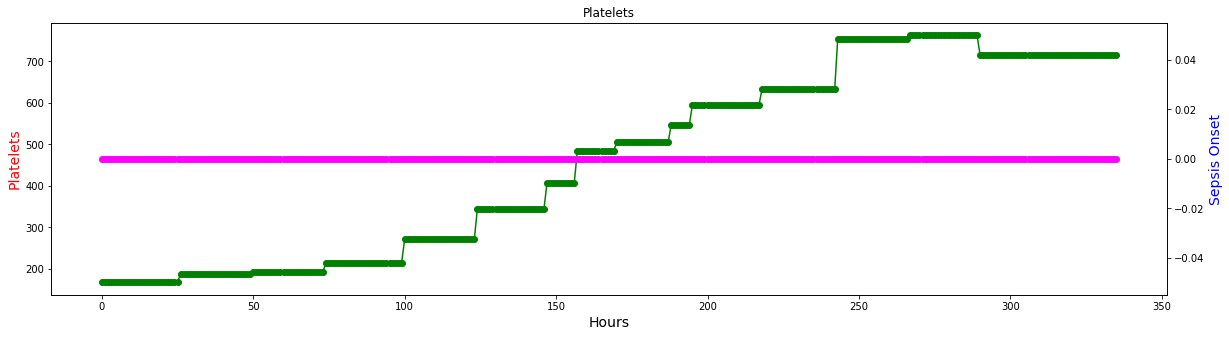

In [221]:
indicators = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP',
       'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2',
       'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride',
       'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium',
       'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb',
       'PTT', 'WBC', 'Fibrinogen', 'Platelets']
for foo in indicators:
    plot_sepsis_covariates(foo,example_non_sepsis,'green','magenta')

Before getting the covariates for the whole thing, lets just see how one indicators varies with another indicator for just one patient, then do for both sepsis and non sepsis

In [226]:
print('Number of pairwise comparisons ',34*33 / 2)


Number of pairwise comparisons  561.0


Too many to plot! just got the covariance matrix and pick a few with the highest r squared to showcase

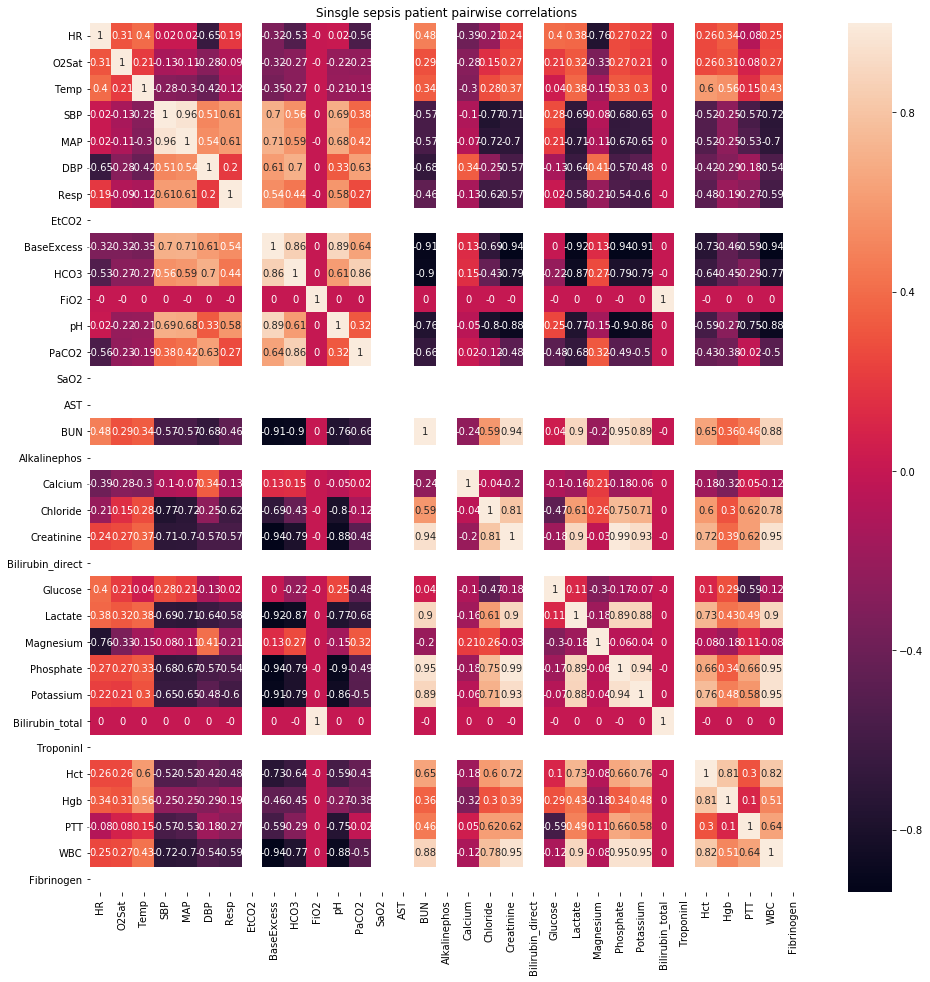

In [244]:
plt.figure(figsize=(16,16))
sns.heatmap(np.round(example_sepsis.iloc[:,2:-9].corr().values,2),
            xticklabels=example_sepsis.iloc[:,2:-9].corr().columns,
            yticklabels=example_sepsis.iloc[:,2:-9].corr().columns,annot=True)
plt.title('Sinsgle sepsis patient pairwise correlations')
plt.show()

#### To do with the full dataset!
* Scan the corr matrix, both sepsis and non sepsis, and pull the top 10 negative and postive r squared comparisons

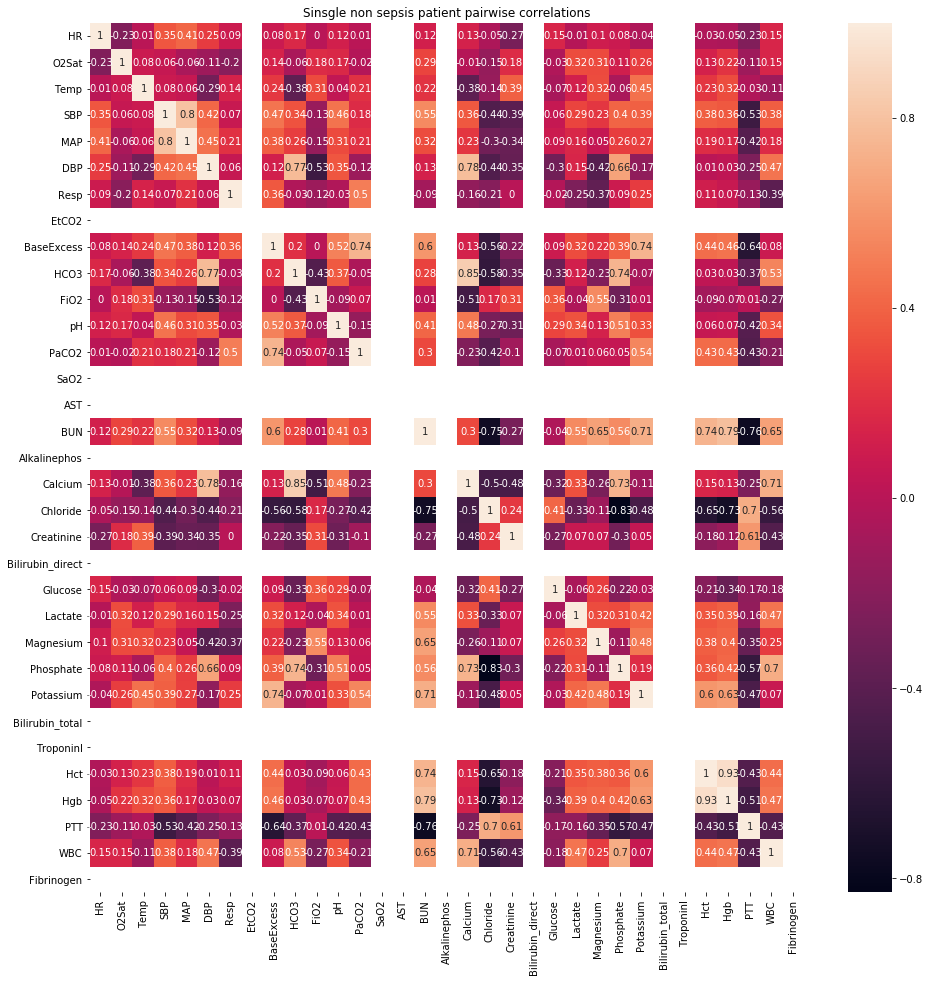

In [245]:
plt.figure(figsize=(16,16))
sns.heatmap(np.round(example_non_sepsis.iloc[:,2:-9].corr().values,2),
            xticklabels=example_non_sepsis.iloc[:,2:-9].corr().columns,
            yticklabels=example_non_sepsis.iloc[:,2:-9].corr().columns,annot=True)
plt.title('Sinsgle non sepsis patient pairwise correlations')
plt.show()

#### To test
* get the difference in the two covaraicnes matrices?? do with the whole dataset afterwards

### Now explore the whole thing

In [246]:
sepsis.head()

PatientID  Delta_t_hours    HR  O2Sat   Temp     SBP   MAP    DBP  Resp  \
0   p014977              0  80.0  100.0  36.50  121.00  58.0  41.00  13.5   
1   p014977              1  76.0  100.0  36.25  113.25  61.0  41.50  12.0   
2   p014977              2  80.0  100.0  36.25  132.75  71.5  46.25  12.0   
3   p014977              3  78.0  100.0  36.10  103.50  58.0  43.00  12.0   
4   p014977              4  74.0  100.0  36.00  128.75  69.5  44.50  12.5   

   EtCO2  BaseExcess  HCO3  FiO2    pH  PaCO2  SaO2  AST   BUN  Alkalinephos  \
0    NaN         1.0  25.0   1.0  7.40   47.0  77.0  NaN  53.0           NaN   
1    NaN         1.0  25.0   0.5  7.40    NaN   NaN  NaN  53.0           NaN   
2    NaN         NaN   NaN   NaN   NaN    NaN   NaN  NaN   NaN           NaN   
3    NaN        -3.0   NaN   NaN  7.34   42.0   NaN  NaN   NaN           NaN   
4    NaN        -3.0   NaN   NaN  7.34    NaN   NaN  NaN   NaN           NaN   

   Calcium  Chloride  Creatinine  Bilirubin_direct  Glucose  Lactate  \
0      NaN     111.0         2.1               NaN    107.0      2.4   
1      NaN     111.0         NaN               NaN      NaN      NaN   
2      NaN       NaN         NaN               NaN      NaN      NaN   
3      NaN       NaN         NaN               NaN    112.5      NaN   
4      NaN       NaN         NaN               NaN      NaN      NaN   

   Magnesium  Phosphate  Potassium  Bilirubin_total  TroponinI   Hct  Hgb  \
0        NaN        NaN        3.7              NaN        NaN  27.9  8.8   
1        NaN        NaN        NaN              NaN        NaN  27.9  8.8   
2        NaN        NaN        NaN              NaN        NaN   NaN  NaN   
3        NaN        NaN        4.2              NaN        NaN   NaN  NaN   
4        NaN        NaN        NaN              NaN        NaN   NaN  NaN   

    PTT  WBC  Fibrinogen  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  \
0  38.1  9.9       223.0      160.0  77.27       1    0.0    1.0        69.14   
1   NaN  9.9         NaN        NaN  77.27       1    0.0    1.0        69.14   
2   NaN  NaN         NaN        NaN  77.27       1    0.0    1.0        69.14   
3   NaN  NaN         NaN        NaN  77.27       1    0.0    1.0        69.14   
4   NaN  NaN         NaN        NaN  77.27       1    0.0    1.0        69.14   

   ICULOS  SepsisLabel  Sepsis_At_All  
0       3            0              0  
1       4            0              0  
2       5            0              0  
3       6            0              0  
4       7            0              0

In [247]:
#what is the distrbution of time intervals for each patient
intervals = []
for a,b in sepsis.groupby('PatientID'):
    intervals.append((a,b.shape[0]))

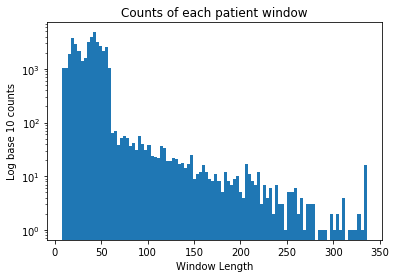

In [253]:
plt.hist([foo[1] for foo in intervals],bins=100)
plt.title('Counts of each patient window')
plt.yscale('log')
plt.ylabel('Log base 10 counts')
plt.xlabel('Window Length')
plt.show()

#### Get the CDF to think about cutoff points

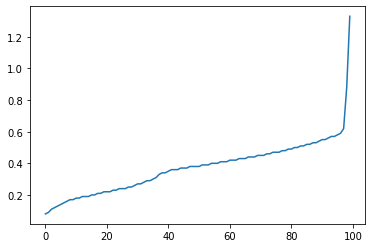

In [263]:
cdfs = [np.percentile([foo[1] for foo in intervals],i) / 100 for i in range(0,100)]
plt.plot(range(0,100),cdfs)
plt.show()

An appropriate windo length would be be between 80 and 100

In [272]:
np.percentile([foo[1] for foo in intervals],90)

55.0

### What do the class distributions look like if if vary wth window length?

In [280]:
sepsis_counts = []
non_sepsis_counts = []
window_lenghts = list(range(50,101))
for length in window_lenghts:
    sepsis_count = 0
    non_sepsis_count = 0
    for a,b in sepsis.groupby('PatientID'):
        #need at lest the length
        if b.shape[0] <= length:
            if b['Sepsis_At_All'][0] == 1:
                sepsis_count += 1
            else:
                non_sepsis_count += 1
        else:
            continue
    sepsis_counts.append(sepsis_count)
    non_sepsis_counts.append(non_sepsis_count)
            

In [328]:
label_counts_vs_window = pd.DataFrame()
label_counts_vs_window['Window_Length'] = window_lenghts
label_counts_vs_window['Count_Sepsis'] = sepsis_counts
label_counts_vs_window['Count_Non_Sepsis'] = non_sepsis_counts
label_counts_vs_window['Percent_of_Whole'] = np.sum(label_counts_vs_window[['Count_Sepsis','Count_Non_Sepsis']].values,axis=1) / len(sepsis['PatientID'].unique())
label_counts_vs_window
label_counts_vs_window = pd.melt(label_counts_vs_window,id_vars=['Window_Length','Percent_of_Whole'])

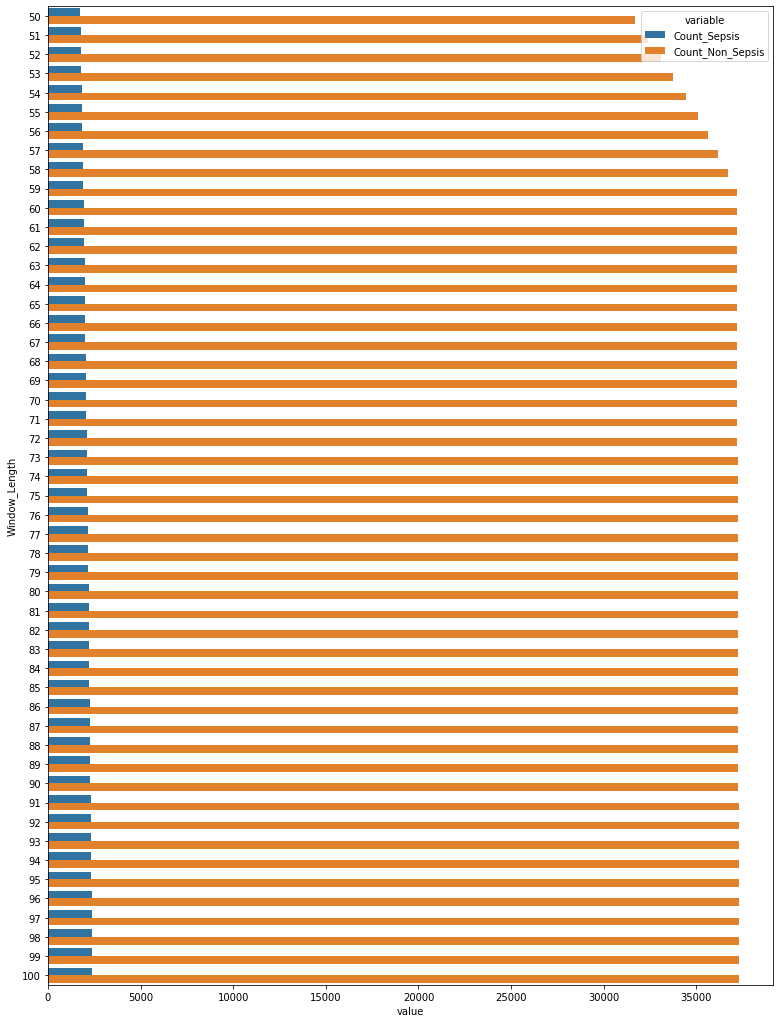

In [347]:
plt.figure(figsize=(13,18))
g = sns.barplot(data=label_counts_vs_window,
            y='Window_Length',x='value',hue='variable',orient='h')

for i,foo in enumerate(g.patches):
    xy = foo.get_xy()
    ax.text(xy[0],xy[1]+10000, str(np.round(label_counts_vs_window['Percent_of_Whole'][i]*100,2)), ha='center',size=11)

plt.show()

In [348]:
label_counts_vs_window = pd.DataFrame()
label_counts_vs_window['Window_Length'] = window_lenghts
label_counts_vs_window['Count_Sepsis'] = sepsis_counts
label_counts_vs_window['Count_Non_Sepsis'] = non_sepsis_counts
label_counts_vs_window['Percent_of_Whole'] = np.sum(label_counts_vs_window[['Count_Sepsis','Count_Non_Sepsis']].values,axis=1) / len(sepsis['PatientID'].unique())
label_counts_vs_window

Window_Length  Count_Sepsis  Count_Non_Sepsis  Percent_of_Whole
0              50          1749             31698          0.829210
1              51          1774             32402          0.847283
2              52          1787             33080          0.864414
3              53          1805             33755          0.881595
4              54          1826             34434          0.898949
5              55          1847             35067          0.915163
6              56          1862             35642          0.929790
7              57          1884             36186          0.943822
8              58          1897             36720          0.957383
9              59          1913             37175          0.969060
10             60          1924             37180          0.969457
11             61          1940             37185          0.969977
12             62          1956             37188          0.970448
13             63          1974             37194          0.971043
14             64          1986             37197          0.971415
15             65          1999             37202          0.971861
16             66          2011             37211          0.972382
17             67          2025             37214          0.972803
18             68          2037             37216          0.973151
19             69          2048             37217          0.973448
20             70          2059             37219          0.973770
21             71          2067             37221          0.974018
22             72          2082             37224          0.974464
23             73          2100             37229          0.975035
24             74          2114             37231          0.975431
25             75          2129             37233          0.975853
26             76          2146             37239          0.976423
27             77          2160             37241          0.976820
28             78          2168             37244          0.977092
29             79          2180             37246          0.977440
30             80          2191             37246          0.977712
31             81          2204             37247          0.978059
32             82          2217             37249          0.978431
33             83          2223             37250          0.978605
34             84          2233             37252          0.978902
35             85          2241             37255          0.979175
36             86          2254             37261          0.979646
37             87          2259             37262          0.979795
38             88          2268             37264          0.980067
39             89          2275             37271          0.980415
40             90          2291             37275          0.980910
41             91          2299             37279          0.981208
42             92          2309             37281          0.981505
43             93          2317             37285          0.981803
44             94          2329             37287          0.982150
45             95          2335             37288          0.982323
46             96          2350             37292          0.982795
47             97          2358             37293          0.983018
48             98          2371             37296          0.983414
49             99          2376             37297          0.983563
50            100          2383             37297          0.983737

* I think just starting off, use T_step of 100, i should cpature most of the data
* Now get the covariance matrices for both sepsis and nonsepsis patietnts
* Show a few corr plots for the highest ones

In [349]:
sepsis.head()

PatientID  Delta_t_hours    HR  O2Sat   Temp     SBP   MAP    DBP  Resp  \
0   p014977              0  80.0  100.0  36.50  121.00  58.0  41.00  13.5   
1   p014977              1  76.0  100.0  36.25  113.25  61.0  41.50  12.0   
2   p014977              2  80.0  100.0  36.25  132.75  71.5  46.25  12.0   
3   p014977              3  78.0  100.0  36.10  103.50  58.0  43.00  12.0   
4   p014977              4  74.0  100.0  36.00  128.75  69.5  44.50  12.5   

   EtCO2  BaseExcess  HCO3  FiO2    pH  PaCO2  SaO2  AST   BUN  Alkalinephos  \
0    NaN         1.0  25.0   1.0  7.40   47.0  77.0  NaN  53.0           NaN   
1    NaN         1.0  25.0   0.5  7.40    NaN   NaN  NaN  53.0           NaN   
2    NaN         NaN   NaN   NaN   NaN    NaN   NaN  NaN   NaN           NaN   
3    NaN        -3.0   NaN   NaN  7.34   42.0   NaN  NaN   NaN           NaN   
4    NaN        -3.0   NaN   NaN  7.34    NaN   NaN  NaN   NaN           NaN   

   Calcium  Chloride  Creatinine  Bilirubin_direct  Glucose  Lactate  \
0      NaN     111.0         2.1               NaN    107.0      2.4   
1      NaN     111.0         NaN               NaN      NaN      NaN   
2      NaN       NaN         NaN               NaN      NaN      NaN   
3      NaN       NaN         NaN               NaN    112.5      NaN   
4      NaN       NaN         NaN               NaN      NaN      NaN   

   Magnesium  Phosphate  Potassium  Bilirubin_total  TroponinI   Hct  Hgb  \
0        NaN        NaN        3.7              NaN        NaN  27.9  8.8   
1        NaN        NaN        NaN              NaN        NaN  27.9  8.8   
2        NaN        NaN        NaN              NaN        NaN   NaN  NaN   
3        NaN        NaN        4.2              NaN        NaN   NaN  NaN   
4        NaN        NaN        NaN              NaN        NaN   NaN  NaN   

    PTT  WBC  Fibrinogen  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  \
0  38.1  9.9       223.0      160.0  77.27       1    0.0    1.0        69.14   
1   NaN  9.9         NaN        NaN  77.27       1    0.0    1.0        69.14   
2   NaN  NaN         NaN        NaN  77.27       1    0.0    1.0        69.14   
3   NaN  NaN         NaN        NaN  77.27       1    0.0    1.0        69.14   
4   NaN  NaN         NaN        NaN  77.27       1    0.0    1.0        69.14   

   ICULOS  SepsisLabel  Sepsis_At_All  
0       3            0              0  
1       4            0              0  
2       5            0              0  
3       6            0              0  
4       7            0              0

In [351]:
sepsis[sepsis['Sepsis_At_All'] == 1].shape,sepsis[sepsis['Sepsis_At_All'] == 0].shape

((172410, 44), (1379800, 44))

### Sepsis Patients Covariates

In [4]:
sepsis[sepsis['Sepsis_At_All'] == 1].iloc[:,2:-9].corr()

HR     O2Sat      Temp       SBP       MAP       DBP  \
HR                1.000000 -0.109060  0.236990 -0.049920  0.086702  0.176895   
O2Sat            -0.109060  1.000000 -0.002645  0.048343  0.043074  0.015385   
Temp              0.236990 -0.002645  1.000000  0.081967  0.028837 -0.001251   
SBP              -0.049920  0.048343  0.081967  1.000000  0.767884  0.506793   
MAP               0.086702  0.043074  0.028837  0.767884  1.000000  0.823452   
DBP               0.176895  0.015385 -0.001251  0.506793  0.823452  1.000000   
Resp              0.234715 -0.165782  0.107619  0.025251  0.033125  0.058116   
EtCO2            -0.000677 -0.013739  0.148170  0.129351  0.102046  0.088259   
BaseExcess       -0.096467  0.006859  0.263864  0.149857  0.102220  0.061738   
HCO3             -0.052424 -0.018819  0.196192  0.086124  0.044746  0.031715   
FiO2              0.060341 -0.113891 -0.158112 -0.052780 -0.040098 -0.015715   
pH               -0.120834  0.089935  0.282973  0.138725  0.095941  0.064392   
PaCO2             0.071295 -0.120969 -0.032781 -0.008030 -0.009185 -0.008858   
SaO2              0.002228  0.134456 -0.033818  0.111466  0.095753  0.062831   
AST              -0.004262 -0.061122 -0.054027 -0.065075 -0.026308 -0.025828   
BUN              -0.064602 -0.068616 -0.129297 -0.047209 -0.100048 -0.117658   
Alkalinephos      0.061506 -0.118058 -0.012855 -0.030291 -0.003571  0.047080   
Calcium          -0.078818  0.102210  0.040006  0.037310  0.007227  0.040171   
Chloride          0.002090  0.139517  0.014875  0.012216  0.031367  0.012271   
Creatinine       -0.047928 -0.035880 -0.127273 -0.066552 -0.082072 -0.078672   
Bilirubin_direct -0.051692  0.004163 -0.119906 -0.040289 -0.082266 -0.041863   
Glucose           0.056105 -0.010205 -0.066376  0.058780  0.060361  0.038412   
Lactate           0.090370 -0.076707 -0.252356 -0.135581 -0.102658 -0.083900   
Magnesium        -0.092316 -0.040169 -0.024638  0.049744  0.018233 -0.012156   
Phosphate        -0.039248 -0.065666 -0.216626 -0.115543 -0.098154 -0.077565   
Potassium         0.014388 -0.036608 -0.013547 -0.109516 -0.082995 -0.063765   
Bilirubin_total  -0.032044 -0.049535 -0.098750 -0.025386 -0.028601  0.018005   
TroponinI         0.045218  0.013002 -0.036834 -0.101499 -0.025346  0.012001   
Hct              -0.034182 -0.092215 -0.036957  0.104292  0.161004  0.187658   
Hgb              -0.037220 -0.074206 -0.055426  0.097953  0.150564  0.184870   
PTT              -0.006978 -0.059281 -0.135349 -0.122597 -0.088932 -0.080332   
WBC               0.118225 -0.059843  0.000175 -0.029721 -0.026326 -0.003382   
Fibrinogen        0.130640 -0.015234  0.336256  0.037448 -0.008527 -0.020671   

                      Resp     EtCO2  BaseExcess      HCO3      FiO2  \
HR                0.234715 -0.000677   -0.096467 -0.052424  0.060341   
O2Sat            -0.165782 -0.013739    0.006859 -0.018819 -0.113891   
Temp              0.107619  0.148170    0.263864  0.196192 -0.158112   
SBP               0.025251  0.129351    0.149857  0.086124 -0.052780   
MAP               0.033125  0.102046    0.102220  0.044746 -0.040098   
DBP               0.058116  0.088259    0.061738  0.031715 -0.015715   
Resp              1.000000 -0.255946   -0.019406 -0.041575  0.143843   
EtCO2            -0.255946  1.000000    0.311754  0.097956 -0.046957   
BaseExcess       -0.019406  0.311754    1.000000  0.875484 -0.140556   
HCO3             -0.041575  0.097956    0.875484  1.000000 -0.088815   
FiO2              0.143843 -0.046957   -0.140556 -0.088815  1.000000   
pH                0.032844 -0.023609    0.663808  0.414321 -0.091581   
PaCO2            -0.057361  0.384508    0.303338  0.527159  0.053852   
SaO2             -0.004956  0.047282    0.058025  0.023277 -0.029757   
AST               0.056483 -0.139101    0.020581 -0.093869  0.100020   
BUN               0.039237  0.012948   -0.181922 -0.190592 -0.044078   
Alkalinephos      0.093756 -0.028391   -0.054239 -0.122291  0.066953   
Calcium

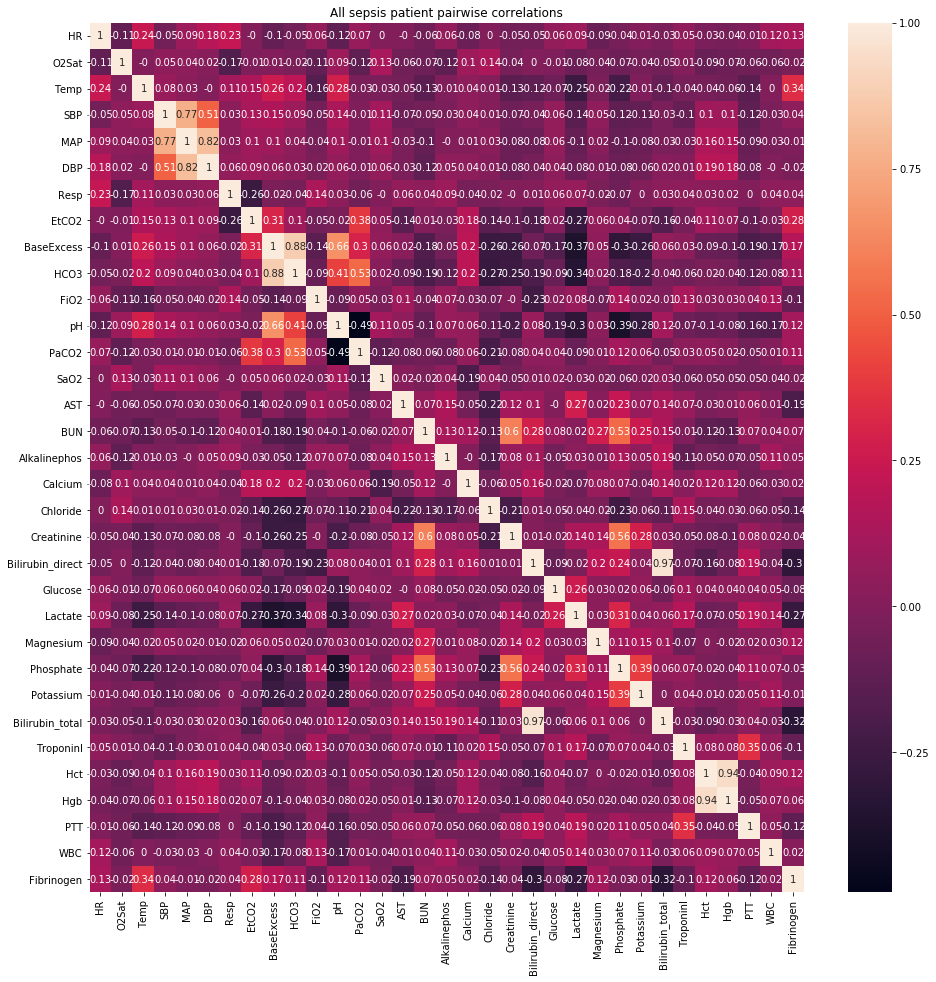

In [3]:
plt.figure(figsize=(16,16))
sns.heatmap(np.round(sepsis[sepsis['Sepsis_At_All'] == 1].iloc[:,2:-9].corr().values,2),
            xticklabels=sepsis[sepsis['Sepsis_At_All'] == 1].iloc[:,2:-9].corr().columns,
            yticklabels=sepsis[sepsis['Sepsis_At_All'] == 1].iloc[:,2:-9].corr().columns,annot=True)
plt.title('All sepsis patient pairwise correlations')
plt.show()

In [4]:
#scan the correlation plot puling the i,j and their values
sepsis_corr = sepsis[sepsis['Sepsis_At_All'] == 1].iloc[:,2:-9].corr().values
corrs_ij = []
for i in range(0,sepsis_corr.shape[0]):
    for j in range(i+1,sepsis_corr.shape[1]):
        corrs_ij.append([sepsis_corr[i][j],i,j])
#sort
corrs_ij.sort(key=lambda x: x[0])
top_5_negative = corrs_ij[:5]
top_5_positive = corrs_ij[-5:]
to_plot = top_5_positive + top_5_negative
columns = sepsis[sepsis['Sepsis_At_All'] == 1].iloc[:,2:-9].corr().columns

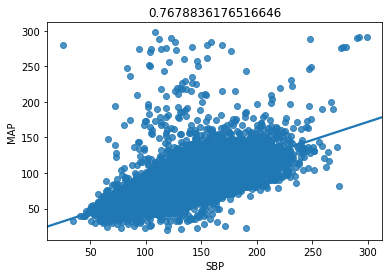

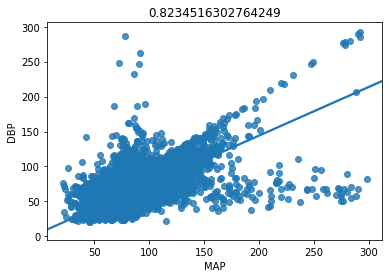

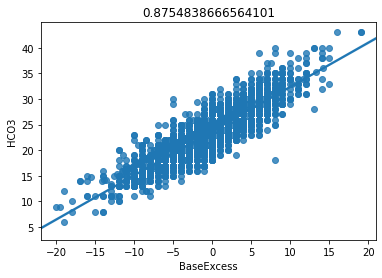

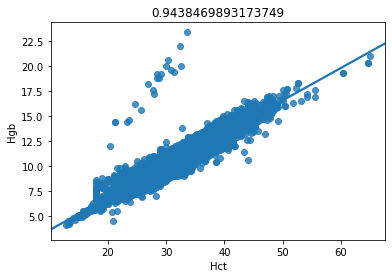

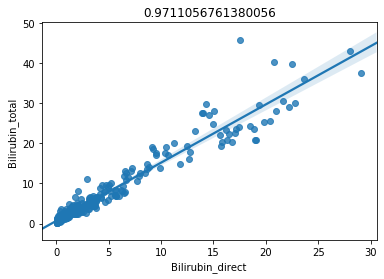

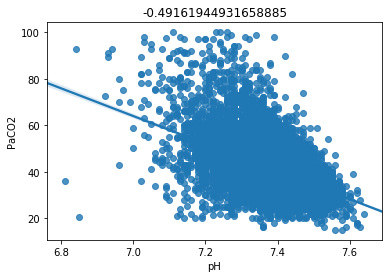

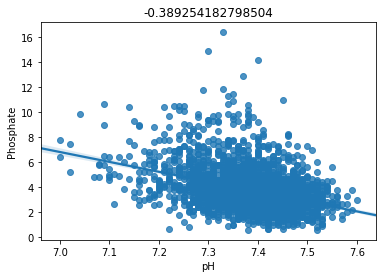

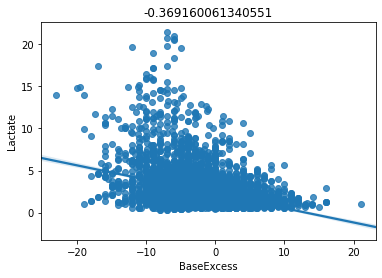

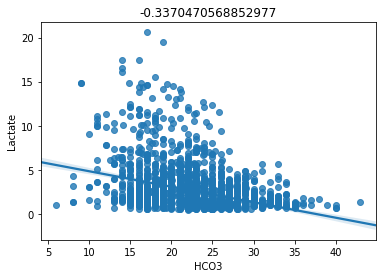

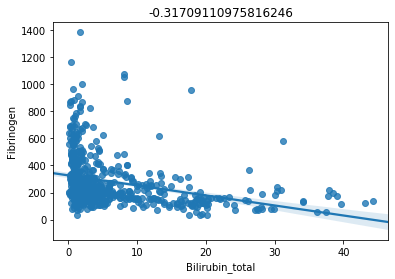

In [6]:
#create plots
#plt.figure(figsize=(13,13))
for i in range(0,len(to_plot)):
    #plt.subplots(520+i)
    sns.regplot(x=columns[to_plot[i][1]],y=columns[to_plot[i][2]],
                data=sepsis[sepsis['Sepsis_At_All'] == 1])
    plt.title(str(to_plot[i][0]))
    plt.show()

### Now lets take a look at the non sepsis patients...
* this is gonna be a big matrix

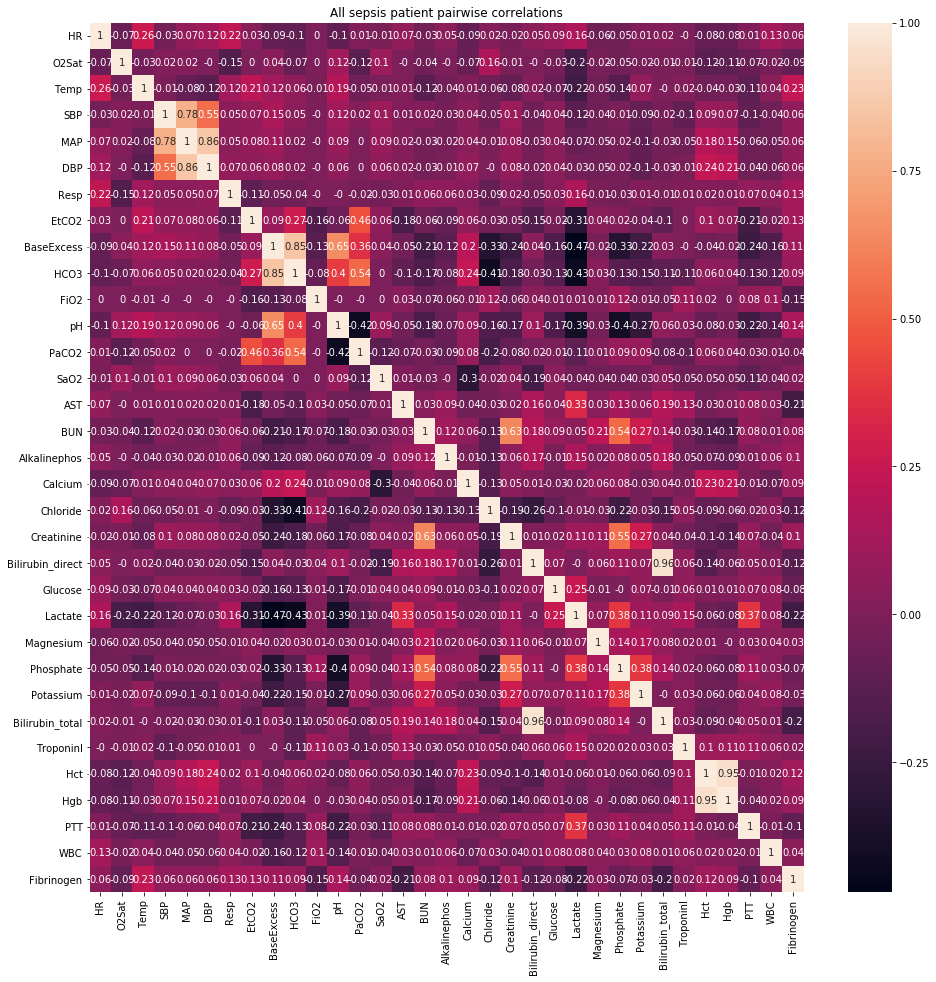

In [7]:
plt.figure(figsize=(16,16))
sns.heatmap(np.round(sepsis[sepsis['Sepsis_At_All'] == 0].iloc[:,2:-9].corr().values,2),
            xticklabels=sepsis[sepsis['Sepsis_At_All'] == 0].iloc[:,2:-9].corr().columns,
            yticklabels=sepsis[sepsis['Sepsis_At_All'] == 0].iloc[:,2:-9].corr().columns,annot=True)
plt.title('All sepsis patient pairwise correlations')
plt.show()

In [8]:
#scan the correlation plot puling the i,j and their values
non_sepsis_corr = sepsis[sepsis['Sepsis_At_All'] == 0].iloc[:,2:-9].corr().values
corrs_ij = []
for i in range(0,non_sepsis_corr.shape[0]):
    for j in range(i+1,non_sepsis_corr.shape[1]):
        corrs_ij.append([non_sepsis_corr[i][j],i,j])
#sort
corrs_ij.sort(key=lambda x: x[0])
top_5_negative = corrs_ij[:5]
top_5_positive = corrs_ij[-5:]
to_plot = top_5_positive + top_5_negative
columns = sepsis[sepsis['Sepsis_At_All'] == 0].iloc[:,2:-9].corr().columns

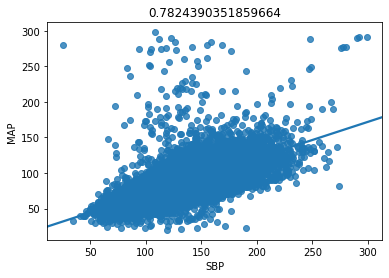

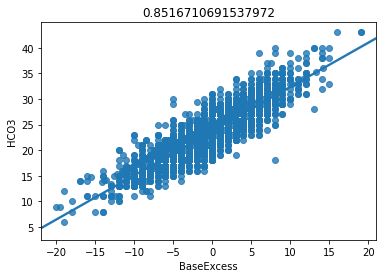

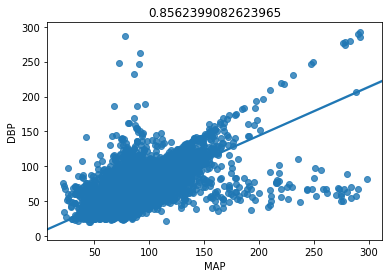

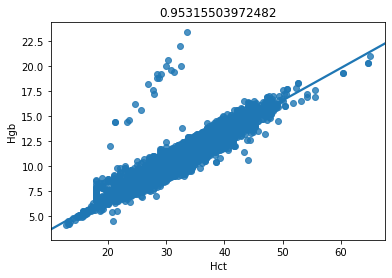

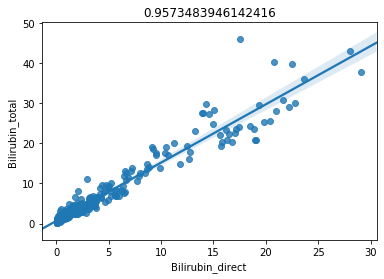

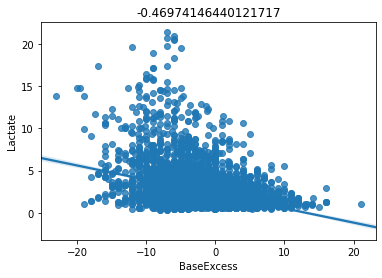

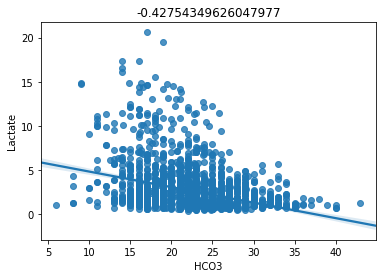

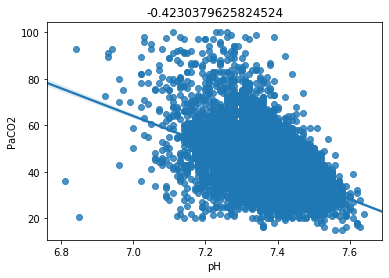

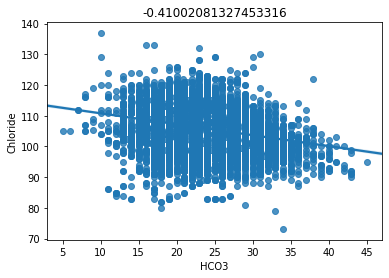

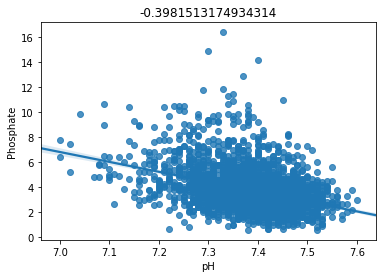

In [10]:
#create plots
#plt.figure(figsize=(13,13))
for i in range(0,len(to_plot)):
    #plt.subplots(520+i)
    sns.regplot(x=columns[to_plot[i][1]],y=columns[to_plot[i][2]],
                data=sepsis[sepsis['Sepsis_At_All'] == 1])
    plt.title(str(to_plot[i][0]))
    plt.show()

Similar covariates between sepsis and non sepsis, but how different are they?

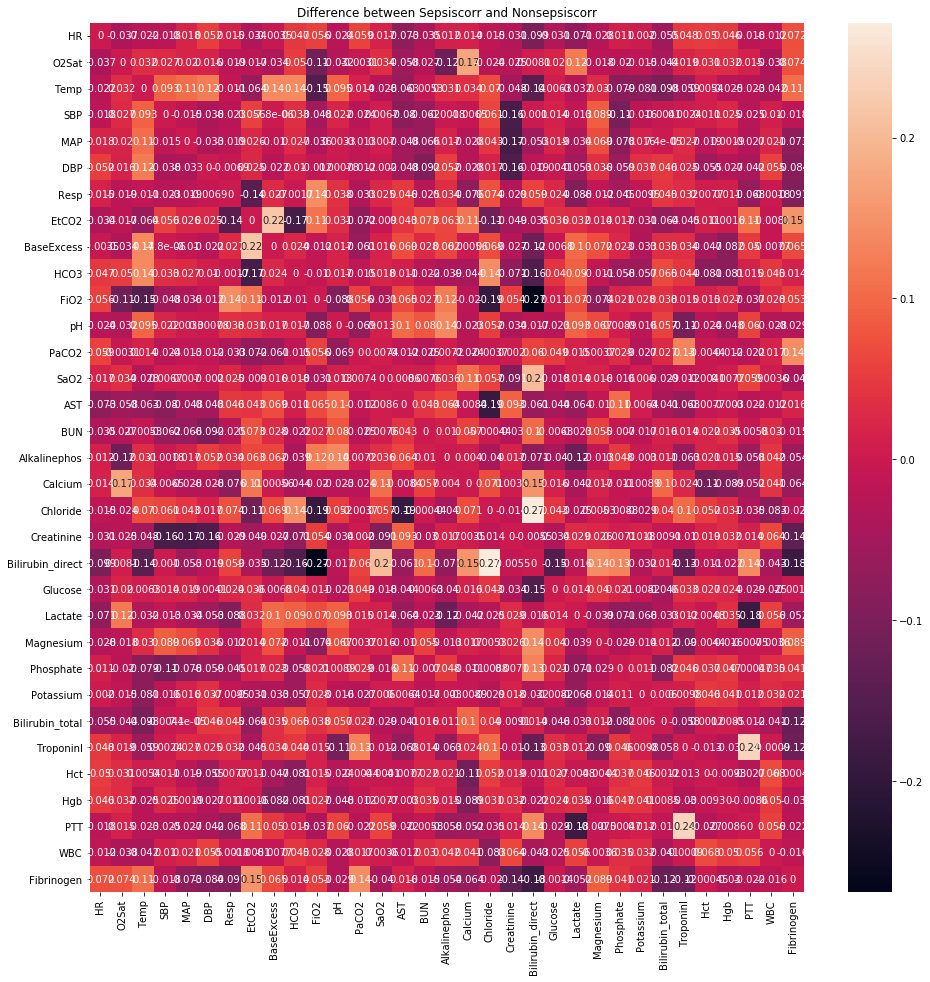

In [13]:
plt.figure(figsize=(16,16))
sns.heatmap(sepsis_corr - non_sepsis_corr,
            xticklabels=sepsis[sepsis['Sepsis_At_All'] == 0].iloc[:,2:-9].corr().columns,
            yticklabels=sepsis[sepsis['Sepsis_At_All'] == 0].iloc[:,2:-9].corr().columns,annot=True)
plt.title('Difference between Sepsiscorr and Nonsepsiscorr')
plt.show()

In [14]:
np.linalg.norm(sepsis_corr-non_sepsis_corr)

2.01162216308653

In [7]:
for i in range(0,len(to_plot)):
    print(11+(i)*10 if i < 5 else (11+1 + (i%5*10))) 

11
21
31
41
51
12
22
32
42
52


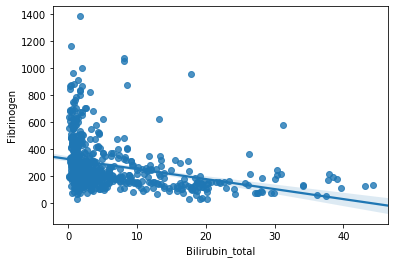

In [409]:
sns.regplot(x=columns[to_plot[i][1]],y=columns[to_plot[i][2]],
                data=sepsis[sepsis['Sepsis_At_All'] == 1])

In a new notebook complete input and output creation

In [18]:
8 // 3

2

In [19]:
8 // 3

2

In [21]:
test = [1,2,3,4,4,5]
test.count(4)

2